In [ ]:
from sage.all import sigma, nth_prime
import pickle

def nieburTau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def primeTau(n):
    return nieburTau(nth_prime(n))   # ✅ works in Sage 10.6

prime_tau_lst = [(0,1)]
for k in range(1, 1001):
    prime_tau_lst.append([k, primeTau(k)])
    print(k)

with open('/Users/barrybrent/data/run27aug25no2.txt', 'wb') as wfile:
    pickle.dump(prime_tau_lst, wfile) #output snipped

import pickle
with open('/Users/barrybrent/data/run27aug25no2.txt', 'rb') as rfile:
    h_list = pickle.load(rfile)
def h(n):
    return h_list[n][1]
j0=1
j_lst=[(0,j0)]
for n in [1..1000]:
    sm=0
    for r in [1..n-1]:
        sm=sm+j_lst[r][1]*h(n-r)
    jn=n*h(n)-sm
    j_lst+=[(n,jn)]
    print(n)

with open('/Users/barrybrent/data/run1sept25no1.txt', 'wb') as wfile:
    pickle.dump(j_lst, wfile) #output snipped

STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: hessenberg_form() got an unexpected keyword argument 'transformation'

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 15
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 15x15
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021534

Processing P-matrix of size 1x1...
    Computing charac

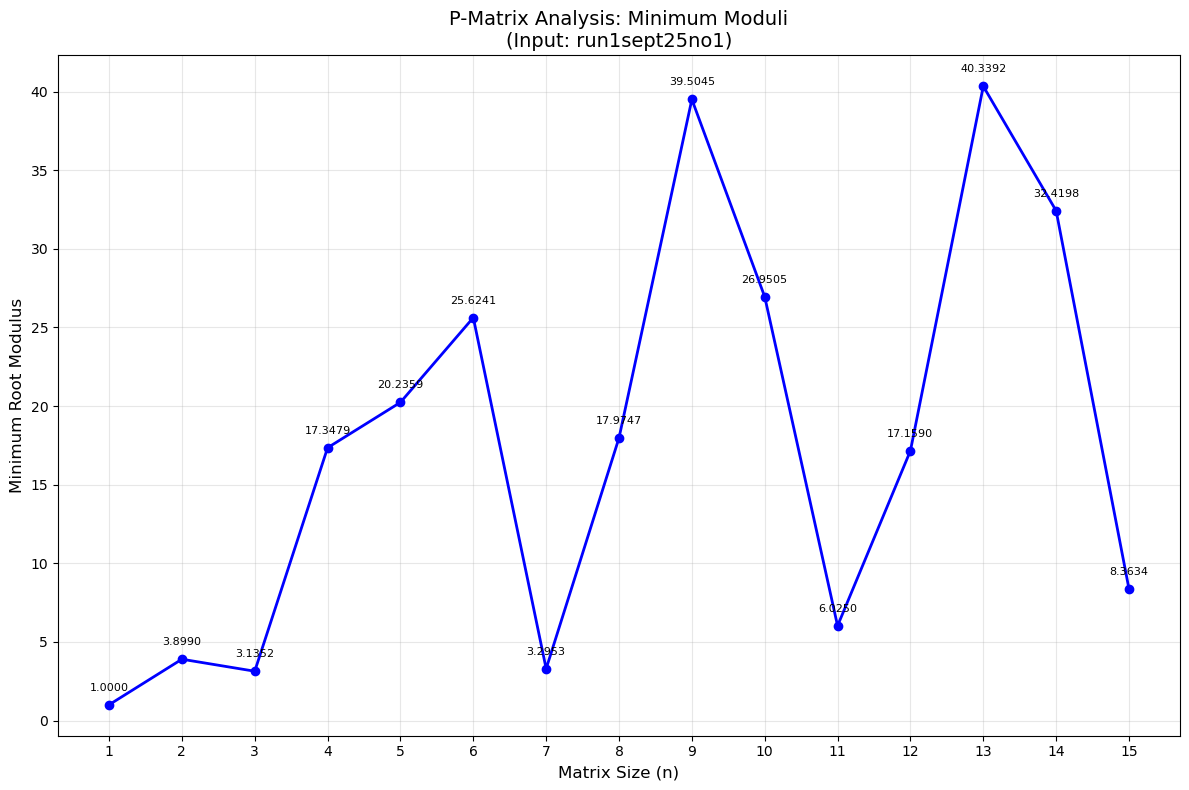


✓ ANALYSIS COMPLETE!
✓ Processed 15 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021534
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 15 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021534


In [1]:
# P-Matrix Analysis Tool - Optimized for Available SageMath Features
# Only constructs P-matrices, uses only working optimization methods

import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

# ============================================================================
# USER INPUTS - MODIFY THESE FOR YOUR ANALYSIS
# ============================================================================

VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'  # ← INPUT 1: Your file path
MAX_MATRICES = 15  # ← INPUT 2: Maximum number of matrices to process (None = all)
OUTPUT_DIR = '/Users/barrybrent/data/'  # ← INPUT 3: Where to save results

# ============================================================================
# OPTIMIZATION SETUP
# ============================================================================

def check_available_optimizations():
    """Check what optimization methods actually work in this SageMath installation."""
    print("Checking available optimization methods...")
    
    # Test integer matrix algorithms (we know 'generic' works from your test)
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    
    # Test Hessenberg form
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form(transformation=True)
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    
    return True

# ============================================================================
# P-MATRIX CONSTRUCTION (ONLY)
# ============================================================================

def construct_p_matrix(n, p_values):
    """
    Construct P-matrix using provided p values according to the structure:
    
    |p₁   -1    0    0   ···   0 |
    |p₂   p₁   -2    0   ···   0 |
    |p₃   p₂   p₁   -3   ···   0 |
    |⋮    ⋮    ⋮    ⋮    ⋱    ⋮ |
    |pₙ   pₙ₋₁ ···  p₂   p₁  -n |
    """
    if len(p_values) < n:
        raise ValueError(f"Need at least {n} p values, got {len(p_values)}")
    
    M = matrix(QQ, n, n)
    p = p_values[:n]  # Use first n values
    
    for i in range(n):
        for j in range(n):
            if j < i:  # Below diagonal
                M[i, j] = p[i - j]  # p_{i+1-j}
            elif j == i:  # Main diagonal
                M[i, j] = p[0]  # p₁ on diagonal
            elif j == i + 1 and i < n - 1:  # Superdiagonal (except last row)
                M[i, j] = -(i + 1)  # -1, -2, -3, ..., -(n-1)
            elif i == n - 1 and j == n - 1:  # Bottom-right corner
                M[i, j] = -n
            else:  # All other positions
                M[i, j] = 0
    
    return M

# ============================================================================
# FILE INPUT
# ============================================================================

def load_values_from_file(filename):
    """Load numerical values from file."""
    values = []
    
    # Try pickle file first
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        if isinstance(data, list) and len(data) > 0:
            if isinstance(data[0], (tuple, list)) and len(data[0]) == 2:
                # Extract values from (index, value) pairs
                values = [QQ(pair[1]) for pair in data]
                print(f"✓ Loaded {len(values)} values from pickled file")
                return values
            else:
                values = [QQ(val) for val in data]
                print(f"✓ Loaded {len(values)} values from pickled file")
                return values
                
    except Exception as e:
        print(f"Could not load as pickle: {e}")
        
    # Fallback to text file
    try:
        with open(filename, 'r') as f:
            content = f.read().strip()
        
        # Parse values from text
        for line in content.split('\n'):
            line = line.strip()
            if line and not line.startswith('#'):
                if ',' in line:
                    parts = line.split(',')
                else:
                    parts = line.split()
                
                for part in parts:
                    part = part.strip()
                    if part:
                        try:
                            values.append(QQ(part))
                        except:
                            pass
        
        print(f"✓ Loaded {len(values)} values from text file")
        return values
        
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

# ============================================================================
# POLYNOMIAL AND ROOT ANALYSIS - EXACT METHODS ONLY
# ============================================================================

def compute_characteristic_polynomial_exact(matrix):
    """Compute characteristic polynomial using available exact optimizations."""
    import time
    start_time = time.time()
    
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        
        # For small matrices, use standard method
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        
        # EXACT integer arithmetic optimization (no approximations)
        try:
            # Clear denominators to get integer matrix (completely exact)
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            
            # Use 'generic' algorithm (we know this works from your test)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            
            # Scale back the polynomial exactly
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom^(n-i)) * x^i for i in range(len(coeffs)))
            
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        
        # Try Hessenberg form for larger matrices (exact)
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form(transformation=True)
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        
        # Performance warnings
        if n > 12:
            print(f"    ⚠ WARNING: Matrix size {n}x{n} may be slow")
            if n > 20:
                print(f"    ⚠ Matrix size {n}x{n} could take many minutes")
                print(f"    ⚠ Consider reducing MAX_MATRICES for faster results")
        
        # Fallback: Standard exact method
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
        
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    """Find root with minimum modulus using high precision (exact coefficients)."""
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        
        # Use high precision complex field
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        
        if not roots:
            return None, None, None
        
        # Find minimum modulus root
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        
        # Store with even higher precision for analysis
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
        
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

# ============================================================================
# FILE OUTPUT
# ============================================================================

def setup_output_directory(base_dir, input_file):
    """Create output directory."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    """Save individual matrix data to separate files."""
    
    # Matrix file (human readable)
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    
    # Polynomial file (human readable, exact QQ format)
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        
        # Save coefficients explicitly for reconstruction
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
        f.write(f"Reconstruction: R.<x> = PolynomialRing(QQ); poly = sum(QQ(c)*x^i for i,c in enumerate({[QQ(c) for c in coeffs]}))\n")
    
    # Root data file (human readable)
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    
    # Tuple file (no commentary)
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    """Save consolidated results to summary files."""
    
    # Human readable summary
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    
    # All tuples file (no commentary)
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    
    # Pickle file for easy loading
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def create_plot_with_error_handling(output_dir, n_values, moduli_values, input_file):
    """Create and save plot with robust error handling."""
    try:
        plt.figure(figsize=(12, 8))
        plt.plot(n_values, moduli_values, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Matrix Size (n)', fontsize=12)
        plt.ylabel('Minimum Root Modulus', fontsize=12)
        
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        plt.title(f'P-Matrix Analysis: Minimum Moduli\n(Input: {file_base})', fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.xticks(n_values)
        
        # Add value labels for all points
        for i, (x, y) in enumerate(zip(n_values, moduli_values)):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        
        plt.tight_layout()
        
        # Save plot
        plot_file = os.path.join(output_dir, "minimum_moduli_plot.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {plot_file}")
        
        # Try to show plot, but don't fail if display isn't available
        try:
            plt.show()
        except:
            print("  (Plot display not available, but saved to file)")
        
    except Exception as e:
        print(f"Warning: Could not create plot: {e}")
        print("  Continuing with analysis...")

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None):
    """Complete P-matrix analysis with exact arithmetic."""
    
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    
    # Load values
    values = load_values_from_file(values_file)
    if not values:
        print("❌ No values loaded. Exiting.")
        return []
    
    # Determine matrix count
    if max_n is None:
        max_n = len(values)
    else:
        max_n = min(max_n, len(values))
    
    print(f"Available values: {len(values)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    
    # Setup output
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    
    # Process each matrix
    for n in range(1, max_n + 1):
        print(f"\nProcessing P-matrix of size {n}x{n}...")
        
        try:
            # Construct P-matrix
            matrix = construct_p_matrix(n, values)
            
            # Compute characteristic polynomial (exact)
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                print(f"  ❌ Failed to compute polynomial")
                continue
            
            # Find minimum modulus root
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                print(f"  ❌ Failed to find roots")
                continue
            
            # Save data
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            
            # Store results
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            
            print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
            
        except Exception as e:
            print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    
    # Save consolidated results
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, values)
    
    # Create plot
    if n_values and moduli_values:
        create_plot_with_error_handling(output_dir, n_values, moduli_values, values_file)
    
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    
    return results, output_dir

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    
    # Check available optimizations
    optimizations_available = check_available_optimizations()
    
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    
    # Run analysis
    try:
        results, output_directory = analyze_p_matrices(VALUES_FILE, max_n=MAX_MATRICES, output_base_dir=OUTPUT_DIR)
        
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
            
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()

STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: hessenberg_form() got an unexpected keyword argument 'transformation'

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 250
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 250x250
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021631

Processing P-matrix of size 1x1...
    Computing cha

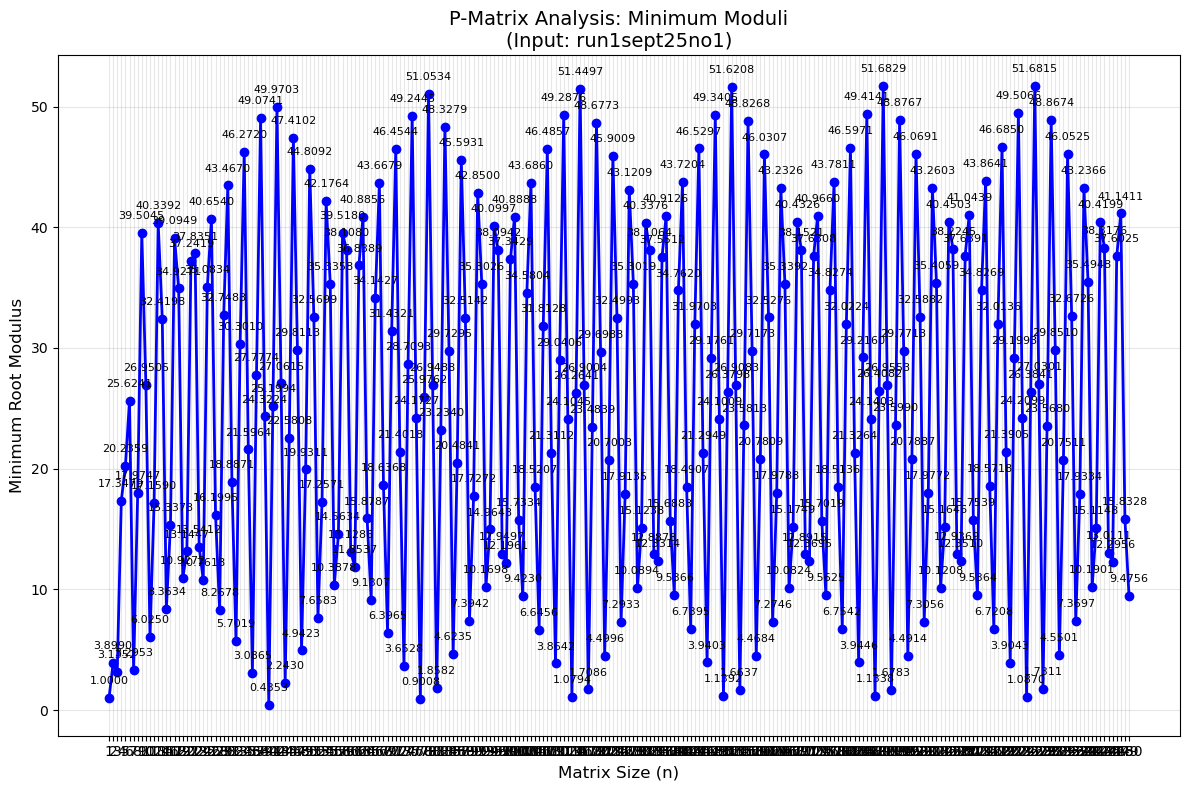


✓ ANALYSIS COMPLETE!
✓ Processed 250 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021631
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 250 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021631


In [2]:
# P-Matrix Analysis Tool - Optimized for Available SageMath Features
# Only constructs P-matrices, uses only working optimization methods

import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

# ============================================================================
# USER INPUTS - MODIFY THESE FOR YOUR ANALYSIS
# ============================================================================

VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'  # ← INPUT 1: Your file path
MAX_MATRICES = 250  # ← INPUT 2: Maximum number of matrices to process (None = all)
OUTPUT_DIR = '/Users/barrybrent/data/'  # ← INPUT 3: Where to save results

# ============================================================================
# OPTIMIZATION SETUP
# ============================================================================

def check_available_optimizations():
    """Check what optimization methods actually work in this SageMath installation."""
    print("Checking available optimization methods...")
    
    # Test integer matrix algorithms (we know 'generic' works from your test)
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    
    # Test Hessenberg form
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form(transformation=True)
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    
    return True

# ============================================================================
# P-MATRIX CONSTRUCTION (ONLY)
# ============================================================================

def construct_p_matrix(n, p_values):
    """
    Construct P-matrix using provided p values according to the structure:
    
    |p₁   -1    0    0   ···   0 |
    |p₂   p₁   -2    0   ···   0 |
    |p₃   p₂   p₁   -3   ···   0 |
    |⋮    ⋮    ⋮    ⋮    ⋱    ⋮ |
    |pₙ   pₙ₋₁ ···  p₂   p₁  -n |
    """
    if len(p_values) < n:
        raise ValueError(f"Need at least {n} p values, got {len(p_values)}")
    
    M = matrix(QQ, n, n)
    p = p_values[:n]  # Use first n values
    
    for i in range(n):
        for j in range(n):
            if j < i:  # Below diagonal
                M[i, j] = p[i - j]  # p_{i+1-j}
            elif j == i:  # Main diagonal
                M[i, j] = p[0]  # p₁ on diagonal
            elif j == i + 1 and i < n - 1:  # Superdiagonal (except last row)
                M[i, j] = -(i + 1)  # -1, -2, -3, ..., -(n-1)
            elif i == n - 1 and j == n - 1:  # Bottom-right corner
                M[i, j] = -n
            else:  # All other positions
                M[i, j] = 0
    
    return M

# ============================================================================
# FILE INPUT
# ============================================================================

def load_values_from_file(filename):
    """Load numerical values from file."""
    values = []
    
    # Try pickle file first
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        if isinstance(data, list) and len(data) > 0:
            if isinstance(data[0], (tuple, list)) and len(data[0]) == 2:
                # Extract values from (index, value) pairs
                values = [QQ(pair[1]) for pair in data]
                print(f"✓ Loaded {len(values)} values from pickled file")
                return values
            else:
                values = [QQ(val) for val in data]
                print(f"✓ Loaded {len(values)} values from pickled file")
                return values
                
    except Exception as e:
        print(f"Could not load as pickle: {e}")
        
    # Fallback to text file
    try:
        with open(filename, 'r') as f:
            content = f.read().strip()
        
        # Parse values from text
        for line in content.split('\n'):
            line = line.strip()
            if line and not line.startswith('#'):
                if ',' in line:
                    parts = line.split(',')
                else:
                    parts = line.split()
                
                for part in parts:
                    part = part.strip()
                    if part:
                        try:
                            values.append(QQ(part))
                        except:
                            pass
        
        print(f"✓ Loaded {len(values)} values from text file")
        return values
        
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

# ============================================================================
# POLYNOMIAL AND ROOT ANALYSIS - EXACT METHODS ONLY
# ============================================================================

def compute_characteristic_polynomial_exact(matrix):
    """Compute characteristic polynomial using available exact optimizations."""
    import time
    start_time = time.time()
    
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        
        # For small matrices, use standard method
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        
        # EXACT integer arithmetic optimization (no approximations)
        try:
            # Clear denominators to get integer matrix (completely exact)
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            
            # Use 'generic' algorithm (we know this works from your test)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            
            # Scale back the polynomial exactly
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom^(n-i)) * x^i for i in range(len(coeffs)))
            
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        
        # Try Hessenberg form for larger matrices (exact)
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form(transformation=True)
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        
        # Performance warnings
        if n > 12:
            print(f"    ⚠ WARNING: Matrix size {n}x{n} may be slow")
            if n > 20:
                print(f"    ⚠ Matrix size {n}x{n} could take many minutes")
                print(f"    ⚠ Consider reducing MAX_MATRICES for faster results")
        
        # Fallback: Standard exact method
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
        
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    """Find root with minimum modulus using high precision (exact coefficients)."""
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        
        # Use high precision complex field
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        
        if not roots:
            return None, None, None
        
        # Find minimum modulus root
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        
        # Store with even higher precision for analysis
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
        
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

# ============================================================================
# FILE OUTPUT
# ============================================================================

def setup_output_directory(base_dir, input_file):
    """Create output directory."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    """Save individual matrix data to separate files."""
    
    # Matrix file (human readable)
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    
    # Polynomial file (human readable, exact QQ format)
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        
        # Save coefficients explicitly for reconstruction
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
        f.write(f"Reconstruction: R.<x> = PolynomialRing(QQ); poly = sum(QQ(c)*x^i for i,c in enumerate({[QQ(c) for c in coeffs]}))\n")
    
    # Root data file (human readable)
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    
    # Tuple file (no commentary)
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    """Save consolidated results to summary files."""
    
    # Human readable summary
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    
    # All tuples file (no commentary)
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    
    # Pickle file for easy loading
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def create_plot_with_error_handling(output_dir, n_values, moduli_values, input_file):
    """Create and save plot with robust error handling."""
    try:
        plt.figure(figsize=(12, 8))
        plt.plot(n_values, moduli_values, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Matrix Size (n)', fontsize=12)
        plt.ylabel('Minimum Root Modulus', fontsize=12)
        
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        plt.title(f'P-Matrix Analysis: Minimum Moduli\n(Input: {file_base})', fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.xticks(n_values)
        
        # Add value labels for all points
        for i, (x, y) in enumerate(zip(n_values, moduli_values)):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        
        plt.tight_layout()
        
        # Save plot
        plot_file = os.path.join(output_dir, "minimum_moduli_plot.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {plot_file}")
        
        # Try to show plot, but don't fail if display isn't available
        try:
            plt.show()
        except:
            print("  (Plot display not available, but saved to file)")
        
    except Exception as e:
        print(f"Warning: Could not create plot: {e}")
        print("  Continuing with analysis...")

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None):
    """Complete P-matrix analysis with exact arithmetic."""
    
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    
    # Load values
    values = load_values_from_file(values_file)
    if not values:
        print("❌ No values loaded. Exiting.")
        return []
    
    # Determine matrix count
    if max_n is None:
        max_n = len(values)
    else:
        max_n = min(max_n, len(values))
    
    print(f"Available values: {len(values)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    
    # Setup output
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    
    # Process each matrix
    for n in range(1, max_n + 1):
        print(f"\nProcessing P-matrix of size {n}x{n}...")
        
        try:
            # Construct P-matrix
            matrix = construct_p_matrix(n, values)
            
            # Compute characteristic polynomial (exact)
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                print(f"  ❌ Failed to compute polynomial")
                continue
            
            # Find minimum modulus root
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                print(f"  ❌ Failed to find roots")
                continue
            
            # Save data
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            
            # Store results
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            
            print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
            
        except Exception as e:
            print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    
    # Save consolidated results
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, values)
    
    # Create plot
    if n_values and moduli_values:
        create_plot_with_error_handling(output_dir, n_values, moduli_values, values_file)
    
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    
    return results, output_dir

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    
    # Check available optimizations
    optimizations_available = check_available_optimizations()
    
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    
    # Run analysis
    try:
        results, output_directory = analyze_p_matrices(VALUES_FILE, max_n=MAX_MATRICES, output_base_dir=OUTPUT_DIR)
        
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
            
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()

In [16]:
# P-Matrix Root Analysis: Complete Implementation
# Block 1: Imports, Configuration, and Directory Detection
# Run this block first

import matplotlib.pyplot as plt
import numpy as np
from sage.all import *
import pickle
import os
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.optimize import curve_fit, differential_evolution
from datetime import datetime
import warnings

# ============================================================================
# USER INPUTS - MODIFY ONLY THE BASE DIRECTORY
# ============================================================================

# Base directory where P-matrix results are stored (the code will find them automatically)
BASE_DATA_DIR = '/Users/barrybrent/data/'  # ← Only path you need to set
OUTPUT_DIR = '/Users/barrybrent/data/periodicity_analysis/'  # ← Where to save this analysis

# Envelope fitting parameters
ENVELOPE_WINDOW = 5  # Window size for envelope detection

print("Configuration loaded:")
print(f"  Base data directory: {BASE_DATA_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Envelope window size: {ENVELOPE_WINDOW}")

# ============================================================================
# AUTOMATIC DIRECTORY DETECTION
# ============================================================================

def find_latest_pmatrix_results(base_dir):
    """
    Find the most recent P-matrix results directory automatically.
    
    Parameters:
    - base_dir: Base directory to search in
    
    Returns:
    - Path to most recent results directory, or None if not found
    """
    import glob
    
    # Pattern to match any P-matrix result directories
    pattern = os.path.join(base_dir, "*_pmatrix_*")
    directories = glob.glob(pattern)
    
    if not directories:
        print(f"No P-matrix result directories found in: {base_dir}")
        print("Expected directories with pattern: *_pmatrix_*")
        return None
    
    # Sort by modification time (most recent first)
    directories.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    latest_dir = directories[0]
    print(f"Found {len(directories)} P-matrix result directories")
    print(f"Using most recent: {os.path.basename(latest_dir)}")
    
    # Verify required files exist
    if not os.path.exists(os.path.join(latest_dir, 'results_data.pkl')):
        print(f"Warning: Required file 'results_data.pkl' not found in {latest_dir}")
        # Try the next most recent directory
        for directory in directories[1:]:
            if os.path.exists(os.path.join(directory, 'results_data.pkl')):
                print(f"Using fallback directory: {os.path.basename(directory)}")
                return directory
        print("No valid P-matrix results directory found")
        return None
    
    return latest_dir

def verify_results_directory(results_dir):
    """
    Verify that the results directory contains valid P-matrix analysis data.
    
    Returns:
    - True if directory is valid, False otherwise
    """
    if not os.path.exists(results_dir):
        print(f"Error: Results directory does not exist: {results_dir}")
        return False
    
    # Check for required files
    required_files = [
        'results_data.pkl',
        'SUMMARY_human_readable.txt'
    ]
    
    missing_files = []
    for req_file in required_files:
        if not os.path.exists(os.path.join(results_dir, req_file)):
            missing_files.append(req_file)
    
    if missing_files:
        print(f"Warning: Missing files in results directory: {missing_files}")
        if 'results_data.pkl' in missing_files:
            print("Error: Critical file 'results_data.pkl' is missing")
            return False
    
    # Check for tuple files (individual matrix results)
    tuple_files = [f for f in os.listdir(results_dir) if f.startswith('tuple_') and f.endswith('.txt')]
    if not tuple_files:
        print("Warning: No tuple files found - may affect detailed analysis")
    else:
        print(f"Found {len(tuple_files)} individual matrix result files")
    
    return True

def load_analysis_results(results_dir):
    """Load results from the P-matrix analysis."""
    
    # Load the pickle file with all data
    pickle_file = os.path.join(results_dir, 'results_data.pkl')
    if not os.path.exists(pickle_file):
        print(f"Error: Could not find {pickle_file}")
        return None
    
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Loaded data for {len(data['n_values'])} matrices")
    print(f"Matrix sizes: {min(data['n_values'])} to {max(data['n_values'])}")
    
    return data

def extract_detailed_root_data(results_dir):
    """Extract high-precision root data from individual files."""
    
    root_files = [f for f in os.listdir(results_dir) if f.startswith('tuple_') and f.endswith('.txt')]
    root_files.sort(key=lambda x: int(x.split('_')[1].split('x')[0]))  # Sort by matrix size
    
    detailed_data = []
    
    for file in root_files:
        filepath = os.path.join(results_dir, file)
        try:
            with open(filepath, 'r') as f:
                line = f.readline().strip()
                # Parse the tuple: (n, polynomial_str, root_str, modulus_str, modulus_float)
                data_tuple = eval(line)
                n, poly_str, root_str, modulus_str, modulus_float = data_tuple
                
                detailed_data.append({
                    'n': n,
                    'polynomial': poly_str,
                    'min_root': root_str,
                    'min_modulus_str': modulus_str,
                    'min_modulus_float': modulus_float
                })
                
        except Exception as e:
            print(f"Warning: Could not parse {file}: {e}")
    
    print(f"Extracted detailed data for {len(detailed_data)} matrices")
    return detailed_data

print("\nBlock 1 complete: All imports, configuration, and directory detection functions loaded.")
print("Ready to proceed to Block 2.")
print("=" * 60)

Configuration loaded:
  Base data directory: /Users/barrybrent/data/
  Output directory: /Users/barrybrent/data/periodicity_analysis/
  Envelope window size: 5

Block 1 complete: All imports, configuration, and directory detection functions loaded.
Ready to proceed to Block 2.


In [17]:
# Block 2: Envelope Detection and Sinusoidal Fitting Functions
# Run this after Block 1

print("Starting Block 2: Envelope Detection and Sinusoidal Fitting Functions")
print("=" * 70)

# ============================================================================
# ENVELOPE DETECTION FUNCTIONS
# ============================================================================

def detect_envelopes(x_values, y_values, window_size=5):
    """
    Detect upper and lower envelopes of the data using local maxima and minima.
    
    Parameters:
    - x_values: array of x coordinates (matrix sizes)
    - y_values: array of y coordinates (minimum moduli)
    - window_size: window for local extrema detection
    
    Returns:
    - upper_envelope: (x_coords, y_coords) of upper envelope
    - lower_envelope: (x_coords, y_coords) of lower envelope
    """
    
    x_array = np.array(x_values)
    y_array = np.array(y_values)
    
    # Find local maxima and minima
    maxima_indices = signal.argrelextrema(y_array, np.greater, order=window_size)[0]
    minima_indices = signal.argrelextrema(y_array, np.less, order=window_size)[0]
    
    # Add endpoints if they're not already included
    if len(maxima_indices) == 0 or maxima_indices[0] != 0:
        maxima_indices = np.concatenate([[0], maxima_indices])
    if len(maxima_indices) == 0 or maxima_indices[-1] != len(y_array) - 1:
        maxima_indices = np.concatenate([maxima_indices, [len(y_array) - 1]])
    
    if len(minima_indices) == 0 or minima_indices[0] != 0:
        minima_indices = np.concatenate([[0], minima_indices])
    if len(minima_indices) == 0 or minima_indices[-1] != len(y_array) - 1:
        minima_indices = np.concatenate([minima_indices, [len(y_array) - 1]])
    
    # Extract envelope points
    upper_x = x_array[maxima_indices]
    upper_y = y_array[maxima_indices]
    lower_x = x_array[minima_indices]
    lower_y = y_array[minima_indices]
    
    # Sort by x-coordinate
    upper_sort = np.argsort(upper_x)
    lower_sort = np.argsort(lower_x)
    
    upper_envelope = (upper_x[upper_sort], upper_y[upper_sort])
    lower_envelope = (lower_x[lower_sort], lower_y[lower_sort])
    
    return upper_envelope, lower_envelope

# ============================================================================
# SINUSOIDAL FITTING FUNCTIONS
# ============================================================================

def sinusoidal_function(x, a, b, c, d):
    """
    Sinusoidal function: y = a + b * sin(c * x + d)
    
    Parameters:
    - a: vertical offset
    - b: amplitude
    - c: frequency parameter
    - d: phase shift
    """
    return a + b * np.sin(c * x + d)

def fit_sinusoidal_envelope(x_data, y_data, method='differential_evolution'):
    """
    Fit sinusoidal function to envelope data with comprehensive error handling.
    
    Parameters:
    - x_data: array of x coordinates
    - y_data: array of y coordinates
    - method: 'curve_fit' or 'differential_evolution'
    
    Returns:
    - params: fitted parameters [a, b, c, d]
    - fit_info: dictionary with fitting statistics
    """
    
    if len(x_data) < 4:
        return None, {'error': 'Insufficient data points for sinusoidal fitting'}
    
    x_array = np.array(x_data)
    y_array = np.array(y_data)
    
    # Normalize x-data to [0, 2π] range for better numerical stability
    x_min, x_max = x_array.min(), x_array.max()
    x_norm = 2 * np.pi * (x_array - x_min) / (x_max - x_min) if x_max > x_min else x_array
    
    # Initial parameter estimates
    a_init = np.mean(y_array)  # vertical offset
    b_init = (np.max(y_array) - np.min(y_array)) / 2  # amplitude
    c_init = 2 * np.pi / len(x_array) if len(x_array) > 1 else 1  # frequency
    d_init = 0  # phase shift
    
    fit_info = {
        'method': method,
        'x_range': (x_min, x_max),
        'y_range': (y_array.min(), y_array.max()),
        'n_points': len(x_data)
    }
    
    try:
        if method == 'curve_fit':
            # Use scipy.optimize.curve_fit
            initial_guess = [a_init, b_init, c_init, d_init]
            
            # Set reasonable bounds
            bounds = (
                [y_array.min() - abs(b_init), -10*abs(b_init), -10, -2*np.pi],
                [y_array.max() + abs(b_init), 10*abs(b_init), 10, 2*np.pi]
            )
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params, covariance = curve_fit(
                    lambda x, a, b, c, d: sinusoidal_function(x, a, b, c, d),
                    x_norm, y_array,
                    p0=initial_guess,
                    bounds=bounds,
                    maxfev=5000
                )
            
            # Scale frequency parameter back to original x-range
            params[2] = params[2] * 2 * np.pi / (x_max - x_min) if x_max > x_min else params[2]
            
            # Calculate fit statistics
            y_pred = sinusoidal_function(x_array, *params)
            
        elif method == 'differential_evolution':
            # Use global optimization
            def objective(params):
                a, b, c, d = params
                y_pred = sinusoidal_function(x_norm, a, b, c, d)
                return np.sum((y_array - y_pred) ** 2)
            
            bounds = [
                (y_array.min() - abs(b_init), y_array.max() + abs(b_init)),  # a
                (-10*abs(b_init), 10*abs(b_init)),  # b
                (-10, 10),  # c
                (-2*np.pi, 2*np.pi)  # d
            ]
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = differential_evolution(objective, bounds, maxiter=1000, seed=42)
            
            if result.success:
                params = result.x
                # Scale frequency parameter back
                params[2] = params[2] * 2 * np.pi / (x_max - x_min) if x_max > x_min else params[2]
                y_pred = sinusoidal_function(x_array, *params)
            else:
                return None, {'error': f'Differential evolution failed: {result.message}'}
        
        else:
            return None, {'error': f'Unknown fitting method: {method}'}
        
        # Calculate comprehensive fit statistics using numpy (no sklearn dependency)
        ss_res = np.sum((y_array - y_pred) ** 2)  # Sum of squares of residuals
        ss_tot = np.sum((y_array - np.mean(y_array)) ** 2)  # Total sum of squares
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        # Calculate RMSE and MAE using numpy
        rmse = np.sqrt(np.mean((y_array - y_pred) ** 2))
        mae = np.mean(np.abs(y_array - y_pred))
        
        # Relative errors
        relative_errors = np.abs((y_array - y_pred) / y_array) * 100
        max_relative_error = np.max(relative_errors)
        mean_relative_error = np.mean(relative_errors)
        
        fit_info.update({
            'params': params,
            'r_squared': r2,
            'rmse': rmse,
            'mae': mae,
            'max_relative_error': max_relative_error,
            'mean_relative_error': mean_relative_error,
            'residuals': y_array - y_pred,
            'y_predicted': y_pred,
            'success': True
        })
        
        return params, fit_info
        
    except Exception as e:
        fit_info.update({
            'error': str(e),
            'success': False
        })
        return None, fit_info

def evaluate_fit_quality(fit_info):
    """
    Evaluate and categorize the quality of a sinusoidal fit.
    
    Returns:
    - quality_score: numerical score from 0 (poor) to 100 (excellent)
    - quality_category: 'Excellent', 'Good', 'Fair', 'Poor'
    - explanation: detailed explanation of the evaluation
    """
    
    if not fit_info.get('success', False):
        return 0, 'Failed', f"Fitting failed: {fit_info.get('error', 'Unknown error')}"
    
    r2 = fit_info['r_squared']
    rmse = fit_info['rmse']
    mae = fit_info['mae']
    mean_rel_error = fit_info['mean_relative_error']
    max_rel_error = fit_info['max_relative_error']
    n_points = fit_info['n_points']
    
    # Calculate quality score (0-100)
    r2_score = max(0, r2 * 40)  # R² contributes up to 40 points
    
    # Relative error scoring (up to 30 points)
    if mean_rel_error < 1:
        rel_error_score = 30
    elif mean_rel_error < 5:
        rel_error_score = 25
    elif mean_rel_error < 10:
        rel_error_score = 20
    elif mean_rel_error < 20:
        rel_error_score = 15
    else:
        rel_error_score = max(0, 30 - mean_rel_error)
    
    # Maximum error penalty (up to 20 points)
    if max_rel_error < 5:
        max_error_score = 20
    elif max_rel_error < 15:
        max_error_score = 15
    elif max_rel_error < 30:
        max_error_score = 10
    else:
        max_error_score = max(0, 20 - max_rel_error / 5)
    
    # Sample size bonus (up to 10 points)
    sample_score = min(10, n_points)
    
    quality_score = r2_score + rel_error_score + max_error_score + sample_score
    
    # Categorize quality
    if quality_score >= 85:
        category = 'Excellent'
    elif quality_score >= 70:
        category = 'Good'
    elif quality_score >= 50:
        category = 'Fair'
    else:
        category = 'Poor'
    
    # Generate explanation
    explanation = f"""
Quality Assessment for Sinusoidal Fit:

OVERALL SCORE: {quality_score:.1f}/100 ({category})

Detailed Metrics:
• R-squared (coefficient of determination): {r2:.4f}
  - Interpretation: {r2*100:.1f}% of variance explained by the model
  - Quality: {'Excellent' if r2 > 0.9 else 'Good' if r2 > 0.7 else 'Fair' if r2 > 0.5 else 'Poor'}

• Root Mean Square Error (RMSE): {rmse:.6f}
  - This is the standard deviation of residuals
  - Smaller values indicate better fit

• Mean Absolute Error (MAE): {mae:.6f}
  - Average absolute difference between actual and predicted values

• Relative Errors:
  - Mean relative error: {mean_rel_error:.2f}%
  - Maximum relative error: {max_rel_error:.2f}%
  - Quality: {'Excellent' if mean_rel_error < 1 else 'Good' if mean_rel_error < 5 else 'Fair' if mean_rel_error < 10 else 'Poor'}

• Sample size: {n_points} data points
  - More points generally enable more reliable fits

INTERPRETATION:
"""
    
    if quality_score >= 85:
        explanation += "The sinusoidal model provides an excellent fit to the envelope data. The fit explains most of the variance with low error rates."
    elif quality_score >= 70:
        explanation += "The sinusoidal model provides a good fit to the envelope data. Some deviations exist but the overall pattern is well captured."
    elif quality_score >= 50:
        explanation += "The sinusoidal model provides a fair fit to the envelope data. The model captures the general trend but significant deviations are present."
    else:
        explanation += "The sinusoidal model provides a poor fit to the envelope data. The data may not follow a sinusoidal pattern, or more complex modeling may be needed."
    
    return quality_score, category, explanation

print("✓ Envelope detection functions loaded:")
print("  - detect_envelopes(): Finds local maxima/minima for envelope points")
print("✓ Sinusoidal fitting functions loaded:")
print("  - sinusoidal_function(): y = a + b*sin(c*x + d)")
print("  - fit_sinusoidal_envelope(): Fits function to envelope data")
print("  - evaluate_fit_quality(): Comprehensive quality assessment with scoring")

print("\nBlock 2 complete: All envelope detection and sinusoidal fitting functions loaded.")
print("Ready to proceed to Block 3.")
print("=" * 70)

Starting Block 2: Envelope Detection and Sinusoidal Fitting Functions
✓ Envelope detection functions loaded:
  - detect_envelopes(): Finds local maxima/minima for envelope points
✓ Sinusoidal fitting functions loaded:
  - sinusoidal_function(): y = a + b*sin(c*x + d)
  - fit_sinusoidal_envelope(): Fits function to envelope data
  - evaluate_fit_quality(): Comprehensive quality assessment with scoring

Block 2 complete: All envelope detection and sinusoidal fitting functions loaded.
Ready to proceed to Block 3.


In [18]:
# Block 3: Enhanced Periodicity Analysis Functions (FIXED VERSION)
# Run this after Block 2

print("Starting Block 3: Enhanced Periodicity Analysis Functions")
print("=" * 70)

# ============================================================================
# ENHANCED PERIODICITY ANALYSIS
# ============================================================================

def analyze_periodicity_patterns(moduli_values, n_values):
    """Comprehensive periodicity analysis using multiple methods."""
    
    moduli_array = np.array(moduli_values)
    n_array = np.array(n_values)
    
    results = {}
    
    # 1. Autocorrelation Analysis
    print("Computing autocorrelation...")
    autocorr = np.correlate(moduli_array - np.mean(moduli_array), 
                           moduli_array - np.mean(moduli_array), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]  # Normalize
    
    # Find peaks in autocorrelation
    peaks, _ = signal.find_peaks(autocorr[1:50], height=0.1, distance=2)
    peaks += 1  # Adjust for starting from index 1
    
    results['autocorr'] = autocorr
    results['autocorr_peaks'] = peaks
    
    # 2. Fourier Analysis
    print("Computing Fourier transform...")
    if len(moduli_array) > 10:
        # Detrend the data first
        detrended = signal.detrend(moduli_array)
        
        # Apply window to reduce spectral leakage
        windowed = detrended * signal.windows.hann(len(detrended))
        
        fft_result = fft(windowed)
        freqs = fftfreq(len(windowed))
        
        # Power spectral density
        psd = np.abs(fft_result)**2
        
        # Find dominant frequencies
        dominant_freq_indices = np.argsort(psd[1:len(psd)//2])[-5:]  # Top 5 frequencies
        dominant_freqs = freqs[1:len(freqs)//2][dominant_freq_indices]
        dominant_periods = 1.0 / np.abs(dominant_freqs[dominant_freqs != 0])
        
        results['fft_freqs'] = freqs[:len(freqs)//2]
        results['psd'] = psd[:len(psd)//2]
        results['dominant_periods'] = dominant_periods
    
    # 3. Envelope Detection and Fitting
    print("Detecting envelopes and fitting sinusoidal functions...")
    upper_envelope, lower_envelope = detect_envelopes(n_values, moduli_values, ENVELOPE_WINDOW)
    
    # Fit sinusoidal functions to envelopes
    upper_params, upper_fit_info = fit_sinusoidal_envelope(upper_envelope[0], upper_envelope[1])
    lower_params, lower_fit_info = fit_sinusoidal_envelope(lower_envelope[0], lower_envelope[1])
    
    # Evaluate fit quality
    if upper_params is not None:
        upper_quality_score, upper_quality_cat, upper_explanation = evaluate_fit_quality(upper_fit_info)
        upper_fit_info.update({
            'quality_score': upper_quality_score,
            'quality_category': upper_quality_cat,
            'quality_explanation': upper_explanation
        })
    
    if lower_params is not None:
        lower_quality_score, lower_quality_cat, lower_explanation = evaluate_fit_quality(lower_fit_info)
        lower_fit_info.update({
            'quality_score': lower_quality_score,
            'quality_category': lower_quality_cat,
            'quality_explanation': lower_explanation
        })
    
    results['envelope_analysis'] = {
        'upper_envelope': upper_envelope,
        'lower_envelope': lower_envelope,
        'upper_fit': {
            'params': upper_params,
            'info': upper_fit_info
        },
        'lower_fit': {
            'params': lower_params,
            'info': lower_fit_info
        }
    }
    
    # 4. Sliding Window Correlation
    print("Computing sliding window correlations...")
    window_sizes = [5, 10, 15, 20, 25, 30]
    correlations = {}
    
    for window in window_sizes:
        if len(moduli_array) > 2 * window:
            corrs = []
            for i in range(len(moduli_array) - 2 * window):
                segment1 = moduli_array[i:i + window]
                segment2 = moduli_array[i + window:i + 2 * window]
                if len(segment1) == len(segment2):
                    corr, _ = pearsonr(segment1, segment2)
                    corrs.append(corr)
            correlations[window] = np.array(corrs)
    
    results['sliding_correlations'] = correlations
    
    # 5. Phase Analysis
    print("Computing phase analysis...")
    if len(moduli_array) > 20:
        # Look for approximate periodic behavior with varying amplitude
        phase_results = {}
        test_periods = range(2, min(50, len(moduli_array) // 3))
        
        for period in test_periods:
            # Reshape data into period-length segments
            num_complete_periods = len(moduli_array) // period
            if num_complete_periods >= 2:
                reshaped = moduli_array[:num_complete_periods * period].reshape(num_complete_periods, period)
                
                # Compute correlation between consecutive periods
                period_corrs = []
                for i in range(num_complete_periods - 1):
                    if np.std(reshaped[i]) > 0 and np.std(reshaped[i+1]) > 0:
                        corr, _ = pearsonr(reshaped[i], reshaped[i+1])
                        period_corrs.append(corr)
                
                if period_corrs:
                    phase_results[period] = {
                        'mean_correlation': np.mean(period_corrs),
                        'std_correlation': np.std(period_corrs),
                        'num_periods': num_complete_periods
                    }
        
        results['phase_analysis'] = phase_results
    
    return results

def detect_approximate_periods(periodicity_results):
    """Detect most likely approximate periods from multiple analysis methods."""
    
    candidate_periods = set()
    
    # From autocorrelation peaks
    if 'autocorr_peaks' in periodicity_results:
        candidate_periods.update(periodicity_results['autocorr_peaks'][:5])  # Top 5 peaks
    
    # From Fourier analysis
    if 'dominant_periods' in periodicity_results:
        # Round to nearest integers and filter reasonable ranges
        integer_periods = [int(round(p)) for p in periodicity_results['dominant_periods'] 
                          if 2 <= p <= 50]
        candidate_periods.update(integer_periods)
    
    # From phase analysis
    if 'phase_analysis' in periodicity_results:
        # Find periods with high mean correlation
        phase_data = periodicity_results['phase_analysis']
        high_corr_periods = [p for p, data in phase_data.items() 
                           if data['mean_correlation'] > 0.3 and data['num_periods'] >= 3]
        candidate_periods.update(high_corr_periods[:5])
    
    return sorted(list(candidate_periods))

# ============================================================================
# DISTANCE CONJECTURE ANALYSIS (FIXED VERSION)
# ============================================================================

def analyze_distance_conjecture(detailed_data):
    """Analyze the conjecture that all roots have modulus > 1."""
    
    print("Analyzing distance conjecture...")
    
    # Extract all minimum moduli with high precision
    moduli_hp = []  # High precision moduli  
    moduli_float = []  # Float approximations
    matrix_sizes = []
    
    for data in detailed_data:
        try:
            # Use the float value directly instead of trying to parse the string as QQ
            modulus_float = data['min_modulus_float']
            moduli_float.append(modulus_float)
            
            # For high precision, convert the decimal string to Sage's RealField
            modulus_str = data['min_modulus_str']
            # Use high precision real field instead of rationals
            RF = RealField(200)  # 200-bit precision
            modulus_hp = RF(modulus_str)
            moduli_hp.append(modulus_hp)
            
            matrix_sizes.append(data['n'])
        except Exception as e:
            print(f"Warning: Could not parse modulus for matrix size {data['n']}: {e}")
    
    if not moduli_float:
        print("Error: No moduli could be parsed")
        return None
    
    # Find global minimum
    global_min_index = np.argmin(moduli_float)
    global_min_modulus = moduli_hp[global_min_index]
    global_min_float = moduli_float[global_min_index]
    global_min_matrix_size = matrix_sizes[global_min_index]
    
    # Distance from 1
    distance_from_one = abs(global_min_modulus - 1)
    
    # Find all "close calls" (moduli < 1.1)
    close_calls = []
    for i, (mod_hp, mod_float, n) in enumerate(zip(moduli_hp, moduli_float, matrix_sizes)):
        if mod_float < 1.1:
            close_calls.append({
                'matrix_size': n,
                'modulus_hp': mod_hp,
                'modulus_float': mod_float,
                'distance_from_one': abs(mod_hp - 1)
            })
    
    # Sort close calls by distance from 1
    close_calls.sort(key=lambda x: float(x['distance_from_one']))
    
    # Statistical analysis
    moduli_array = np.array(moduli_float)
    
    results = {
        'global_minimum': {
            'modulus_hp': global_min_modulus,
            'modulus_float': global_min_float,
            'matrix_size': global_min_matrix_size,
            'distance_from_one': distance_from_one
        },
        'close_calls': close_calls,
        'statistics': {
            'total_matrices': len(moduli_float),
            'min_modulus': np.min(moduli_array),
            'mean_modulus': np.mean(moduli_array),
            'std_modulus': np.std(moduli_array),
            'num_below_1': np.sum(moduli_array < 1.0),
            'num_below_1_1': np.sum(moduli_array < 1.1),
            'num_below_1_01': np.sum(moduli_array < 1.01)
        },
        'all_moduli_hp': moduli_hp,
        'all_moduli_float': moduli_float,
        'matrix_sizes': matrix_sizes
    }
    
    return results

print("✓ Periodicity analysis functions loaded:")
print("  - analyze_periodicity_patterns(): Comprehensive analysis using multiple methods")
print("    * Autocorrelation analysis with peak detection")
print("    * Fourier/spectral analysis for frequency identification")
print("    * Envelope detection and sinusoidal fitting") 
print("    * Sliding window correlations")
print("    * Phase analysis for period validation")
print("  - detect_approximate_periods(): Cross-method period detection")
print("✓ Distance conjecture analysis function loaded (FIXED):")
print("  - analyze_distance_conjecture(): Tests if all roots have modulus > 1")
print("  - Now uses RealField(200) for high precision parsing")

print("\nBlock 3 complete: All periodicity and distance analysis functions loaded.")
print("Ready to proceed to Block 4.")
print("=" * 70)

Starting Block 3: Enhanced Periodicity Analysis Functions
✓ Periodicity analysis functions loaded:
  - analyze_periodicity_patterns(): Comprehensive analysis using multiple methods
    * Autocorrelation analysis with peak detection
    * Fourier/spectral analysis for frequency identification
    * Envelope detection and sinusoidal fitting
    * Sliding window correlations
    * Phase analysis for period validation
  - detect_approximate_periods(): Cross-method period detection
✓ Distance conjecture analysis function loaded (FIXED):
  - analyze_distance_conjecture(): Tests if all roots have modulus > 1
  - Now uses RealField(200) for high precision parsing

Block 3 complete: All periodicity and distance analysis functions loaded.
Ready to proceed to Block 4.


In [19]:
# Block 4: Comprehensive Visualization Functions
# Run this after Block 3

print("Starting Block 4: Comprehensive Visualization Functions")
print("=" * 70)

# ============================================================================
# ENHANCED VISUALIZATION FUNCTIONS
# ============================================================================

def create_comprehensive_plots(periodicity_results, distance_results, output_dir):
    """Create comprehensive visualization including envelope fits."""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Set up the plotting style
    plt.style.use('default')
    # Use matplotlib's built-in color cycle instead of seaborn
    
    moduli = distance_results['all_moduli_float']
    sizes = distance_results['matrix_sizes']
    
    # 1. Main plot with envelope fits
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Main sequence plot with envelopes
    axes[0, 0].plot(sizes, moduli, 'b.-', alpha=0.7, linewidth=1, markersize=3, label='Data')
    axes[0, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='y = 1')
    
    # Plot envelopes and fits
    envelope_data = periodicity_results.get('envelope_analysis', {})
    if envelope_data:
        upper_env = envelope_data['upper_envelope']
        lower_env = envelope_data['lower_envelope']
        
        # Plot envelope points
        axes[0, 0].plot(upper_env[0], upper_env[1], 'ro', markersize=6, alpha=0.8, label='Upper Envelope')
        axes[0, 0].plot(lower_env[0], lower_env[1], 'go', markersize=6, alpha=0.8, label='Lower Envelope')
        
        # Plot fitted curves
        x_fit = np.linspace(min(sizes), max(sizes), 200)
        
        upper_fit = envelope_data['upper_fit']
        if upper_fit['params'] is not None:
            y_upper_fit = sinusoidal_function(x_fit, *upper_fit['params'])
            axes[0, 0].plot(x_fit, y_upper_fit, 'r-', linewidth=2, alpha=0.7, 
                          label=f'Upper Fit (R²={upper_fit["info"]["r_squared"]:.3f})')
        
        lower_fit = envelope_data['lower_fit']
        if lower_fit['params'] is not None:
            y_lower_fit = sinusoidal_function(x_fit, *lower_fit['params'])
            axes[0, 0].plot(x_fit, y_lower_fit, 'g-', linewidth=2, alpha=0.7,
                          label=f'Lower Fit (R²={lower_fit["info"]["r_squared"]:.3f})')
    
    axes[0, 0].set_xlabel('Matrix Size (n)')
    axes[0, 0].set_ylabel('Minimum Root Modulus')
    axes[0, 0].set_title('P-Matrix Minimum Root Moduli with Sinusoidal Envelope Fits')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # 2. Residuals plot for envelope fits
    if envelope_data and envelope_data['upper_fit']['params'] is not None:
        upper_info = envelope_data['upper_fit']['info']
        if 'residuals' in upper_info:
            axes[0, 1].scatter(envelope_data['upper_envelope'][0], upper_info['residuals'], 
                             color='red', alpha=0.7, label='Upper Envelope Residuals')
            axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axes[0, 1].set_xlabel('Matrix Size')
            axes[0, 1].set_ylabel('Residuals')
            axes[0, 1].set_title('Envelope Fit Residuals')
            axes[0, 1].grid(True, alpha=0.3)
    
    if envelope_data and envelope_data['lower_fit']['params'] is not None:
        lower_info = envelope_data['lower_fit']['info']
        if 'residuals' in lower_info:
            axes[0, 1].scatter(envelope_data['lower_envelope'][0], lower_info['residuals'], 
                             color='green', alpha=0.7, label='Lower Envelope Residuals')
            axes[0, 1].legend()
    
    # 3. Autocorrelation plot
    if 'autocorr' in periodicity_results:
        autocorr = periodicity_results['autocorr']
        lags = range(len(autocorr))
        axes[0, 2].plot(lags[:100], autocorr[:100], 'g-', linewidth=2)
        axes[0, 2].set_xlabel('Lag')
        axes[0, 2].set_ylabel('Autocorrelation')
        axes[0, 2].set_title('Autocorrelation Analysis')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Mark peaks
        if 'autocorr_peaks' in periodicity_results:
            peaks = periodicity_results['autocorr_peaks']
            for peak in peaks[:5]:
                if peak < 100:
                    axes[0, 2].plot(peak, autocorr[peak], 'ro', markersize=8)
                    axes[0, 2].annotate(f'{peak}', (peak, autocorr[peak]), 
                                      xytext=(5, 5), textcoords='offset points')
    
    # 4. Power Spectral Density
    if 'psd' in periodicity_results:
        freqs = periodicity_results['fft_freqs']
        psd = periodicity_results['psd']
        axes[1, 0].semilogy(freqs[1:], psd[1:], 'purple', linewidth=1.5)
        axes[1, 0].set_xlabel('Frequency')
        axes[1, 0].set_ylabel('Power Spectral Density (log scale)')
        axes[1, 0].set_title('Fourier Analysis')
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Distribution of moduli
    axes[1, 1].hist(moduli, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Modulus = 1')
    axes[1, 1].axvline(x=distance_results['global_minimum']['modulus_float'], 
                      color='orange', linestyle='-', linewidth=2, label='Global Minimum')
    axes[1, 1].set_xlabel('Minimum Root Modulus')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Minimum Moduli')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Envelope fitting quality comparison
    if envelope_data:
        upper_fit = envelope_data.get('upper_fit', {})
        lower_fit = envelope_data.get('lower_fit', {})
        
        categories = []
        scores = []
        colors = []
        
        if upper_fit.get('params') is not None:
            categories.append('Upper\nEnvelope')
            scores.append(upper_fit['info'].get('quality_score', 0))
            colors.append('red')
        
        if lower_fit.get('params') is not None:
            categories.append('Lower\nEnvelope')
            scores.append(lower_fit['info'].get('quality_score', 0))
            colors.append('green')
        
        if categories:
            bars = axes[1, 2].bar(categories, scores, color=colors, alpha=0.7)
            axes[1, 2].set_ylabel('Quality Score (0-100)')
            axes[1, 2].set_title('Envelope Fit Quality')
            axes[1, 2].set_ylim(0, 100)
            axes[1, 2].grid(True, alpha=0.3, axis='y')
            
            # Add score labels on bars
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                               f'{score:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comprehensive_analysis_with_envelopes.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Detailed envelope fitting plot
    if envelope_data:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Upper envelope detailed plot
        ax1.plot(sizes, moduli, 'b.', alpha=0.5, markersize=2, label='All Data')
        
        upper_env = envelope_data['upper_envelope']
        ax1.plot(upper_env[0], upper_env[1], 'ro', markersize=8, alpha=0.8, 
                label=f'Upper Envelope ({len(upper_env[0])} points)')
        
        upper_fit = envelope_data['upper_fit']
        if upper_fit['params'] is not None:
            x_detailed = np.linspace(min(sizes), max(sizes), 500)
            y_fit = sinusoidal_function(x_detailed, *upper_fit['params'])
            params = upper_fit['params']
            quality = upper_fit['info'].get('quality_category', 'Unknown')
            r2 = upper_fit['info'].get('r_squared', 0)
            
            ax1.plot(x_detailed, y_fit, 'r-', linewidth=3, alpha=0.8,
                    label=f'Fit: y={params[0]:.3f}+{params[1]:.3f}*sin({params[2]:.3f}*x+{params[3]:.3f})')
            ax1.set_title(f'Upper Envelope Fit - {quality} Quality (R² = {r2:.4f})')
        else:
            ax1.set_title('Upper Envelope Fit - Failed')
        
        ax1.set_ylabel('Minimum Root Modulus')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Lower envelope detailed plot
        ax2.plot(sizes, moduli, 'b.', alpha=0.5, markersize=2, label='All Data')
        
        lower_env = envelope_data['lower_envelope']
        ax2.plot(lower_env[0], lower_env[1], 'go', markersize=8, alpha=0.8,
                label=f'Lower Envelope ({len(lower_env[0])} points)')
        
        lower_fit = envelope_data['lower_fit']
        if lower_fit['params'] is not None:
            x_detailed = np.linspace(min(sizes), max(sizes), 500)
            y_fit = sinusoidal_function(x_detailed, *lower_fit['params'])
            params = lower_fit['params']
            quality = lower_fit['info'].get('quality_category', 'Unknown')
            r2 = lower_fit['info'].get('r_squared', 0)
            
            ax2.plot(x_detailed, y_fit, 'g-', linewidth=3, alpha=0.8,
                    label=f'Fit: y={params[0]:.3f}+{params[1]:.3f}*sin({params[2]:.3f}*x+{params[3]:.3f})')
            ax2.set_title(f'Lower Envelope Fit - {quality} Quality (R² = {r2:.4f})')
        else:
            ax2.set_title('Lower Envelope Fit - Failed')
        
        ax2.set_xlabel('Matrix Size (n)')
        ax2.set_ylabel('Minimum Root Modulus')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'detailed_envelope_fits.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Phase analysis plot
    if 'phase_analysis' in periodicity_results:
        phase_data = periodicity_results['phase_analysis']
        if phase_data:
            periods = sorted(phase_data.keys())
            correlations = [phase_data[p]['mean_correlation'] for p in periods]
            
            plt.figure(figsize=(12, 6))
            plt.plot(periods, correlations, 'bo-', linewidth=2, markersize=6)
            plt.xlabel('Tested Period Length')
            plt.ylabel('Mean Correlation Between Consecutive Periods')
            plt.title('Phase Analysis: Periodic Correlation Strength')
            plt.grid(True, alpha=0.3)
            
            # Highlight strong correlations
            strong_periods = [p for p in periods if phase_data[p]['mean_correlation'] > 0.3]
            for p in strong_periods:
                plt.plot(p, phase_data[p]['mean_correlation'], 'ro', markersize=10, alpha=0.7)
                plt.annotate(f'Period {p}', (p, phase_data[p]['mean_correlation']), 
                           xytext=(5, 5), textcoords='offset points')
            
            plt.savefig(os.path.join(output_dir, 'phase_analysis.png'), dpi=300, bbox_inches='tight')
            plt.show()
    
    # 4. Close-up of region near modulus = 1
    plt.figure(figsize=(14, 8))
    
    # Filter data near 1
    near_one_indices = [i for i, mod in enumerate(moduli) if 0.8 < mod < 1.2]
    near_one_sizes = [sizes[i] for i in near_one_indices]
    near_one_moduli = [moduli[i] for i in near_one_indices]
    
    plt.plot(near_one_sizes, near_one_moduli, 'b.-', linewidth=2, markersize=5, alpha=0.8)
    plt.axhline(y=1.0, color='red', linestyle='--', linewidth=3, alpha=0.9, label='Modulus = 1')
    
    # Highlight the global minimum
    global_min = distance_results['global_minimum']
    plt.plot(global_min['matrix_size'], global_min['modulus_float'], 'ro', 
            markersize=12, label=f'Global Min: {global_min["modulus_float"]:.6f}')
    
    plt.xlabel('Matrix Size (n)')
    plt.ylabel('Minimum Root Modulus')
    plt.title('Close-up View: Minimum Moduli Near 1')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, 'closeup_near_one.png'), dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Comprehensive visualization functions loaded:")
print("  - create_comprehensive_plots(): Creates 6 different visualization plots")
print("    * Main sequence plot with envelope fits and sinusoidal curves")
print("    * Residuals plot showing fit quality")
print("    * Autocorrelation plot with peak annotations")
print("    * Power spectral density plot (Fourier analysis)")
print("    * Distribution histogram of minimum moduli")
print("    * Quality comparison bar chart")
print("  - Additional detailed plots:")
print("    * Separate detailed envelope fitting plots")
print("    * Phase analysis correlation plot") 
print("    * Close-up view near modulus = 1")

print("\nBlock 4 complete: All comprehensive visualization functions loaded.")
print("Ready to proceed to Block 5.")
print("=" * 70)

Starting Block 4: Comprehensive Visualization Functions
✓ Comprehensive visualization functions loaded:
  - create_comprehensive_plots(): Creates 6 different visualization plots
    * Main sequence plot with envelope fits and sinusoidal curves
    * Residuals plot showing fit quality
    * Autocorrelation plot with peak annotations
    * Power spectral density plot (Fourier analysis)
    * Distribution histogram of minimum moduli
    * Quality comparison bar chart
  - Additional detailed plots:
    * Separate detailed envelope fitting plots
    * Phase analysis correlation plot
    * Close-up view near modulus = 1

Block 4 complete: All comprehensive visualization functions loaded.
Ready to proceed to Block 5.


Starting Block 5: Report Generation and Main Execution Functions
P-MATRIX PERIODICITY AND ENVELOPE ANALYSIS
Base data directory: /Users/barrybrent/data/
Output directory: /Users/barrybrent/data/periodicity_analysis/
Envelope window size: 5
STARTING COMPREHENSIVE P-MATRIX ANALYSIS
Searching for P-matrix results...
Found 3 P-matrix result directories
Using most recent: run1sept25no1_pmatrix_20250906_021631
Found 250 individual matrix result files
✓ Using results directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021631

Loading analysis results...
Loaded data for 250 matrices
Matrix sizes: 1 to 250
Extracted detailed data for 250 matrices

Analyzing periodicity patterns...
Computing autocorrelation...
Computing Fourier transform...
Detecting envelopes and fitting sinusoidal functions...
Computing sliding window correlations...
Computing phase analysis...
Detected candidate periods: [np.int64(4), np.int64(8), 9, np.int64(12), 13, np.int64(16), np.int64(21)]

Analyzing distan

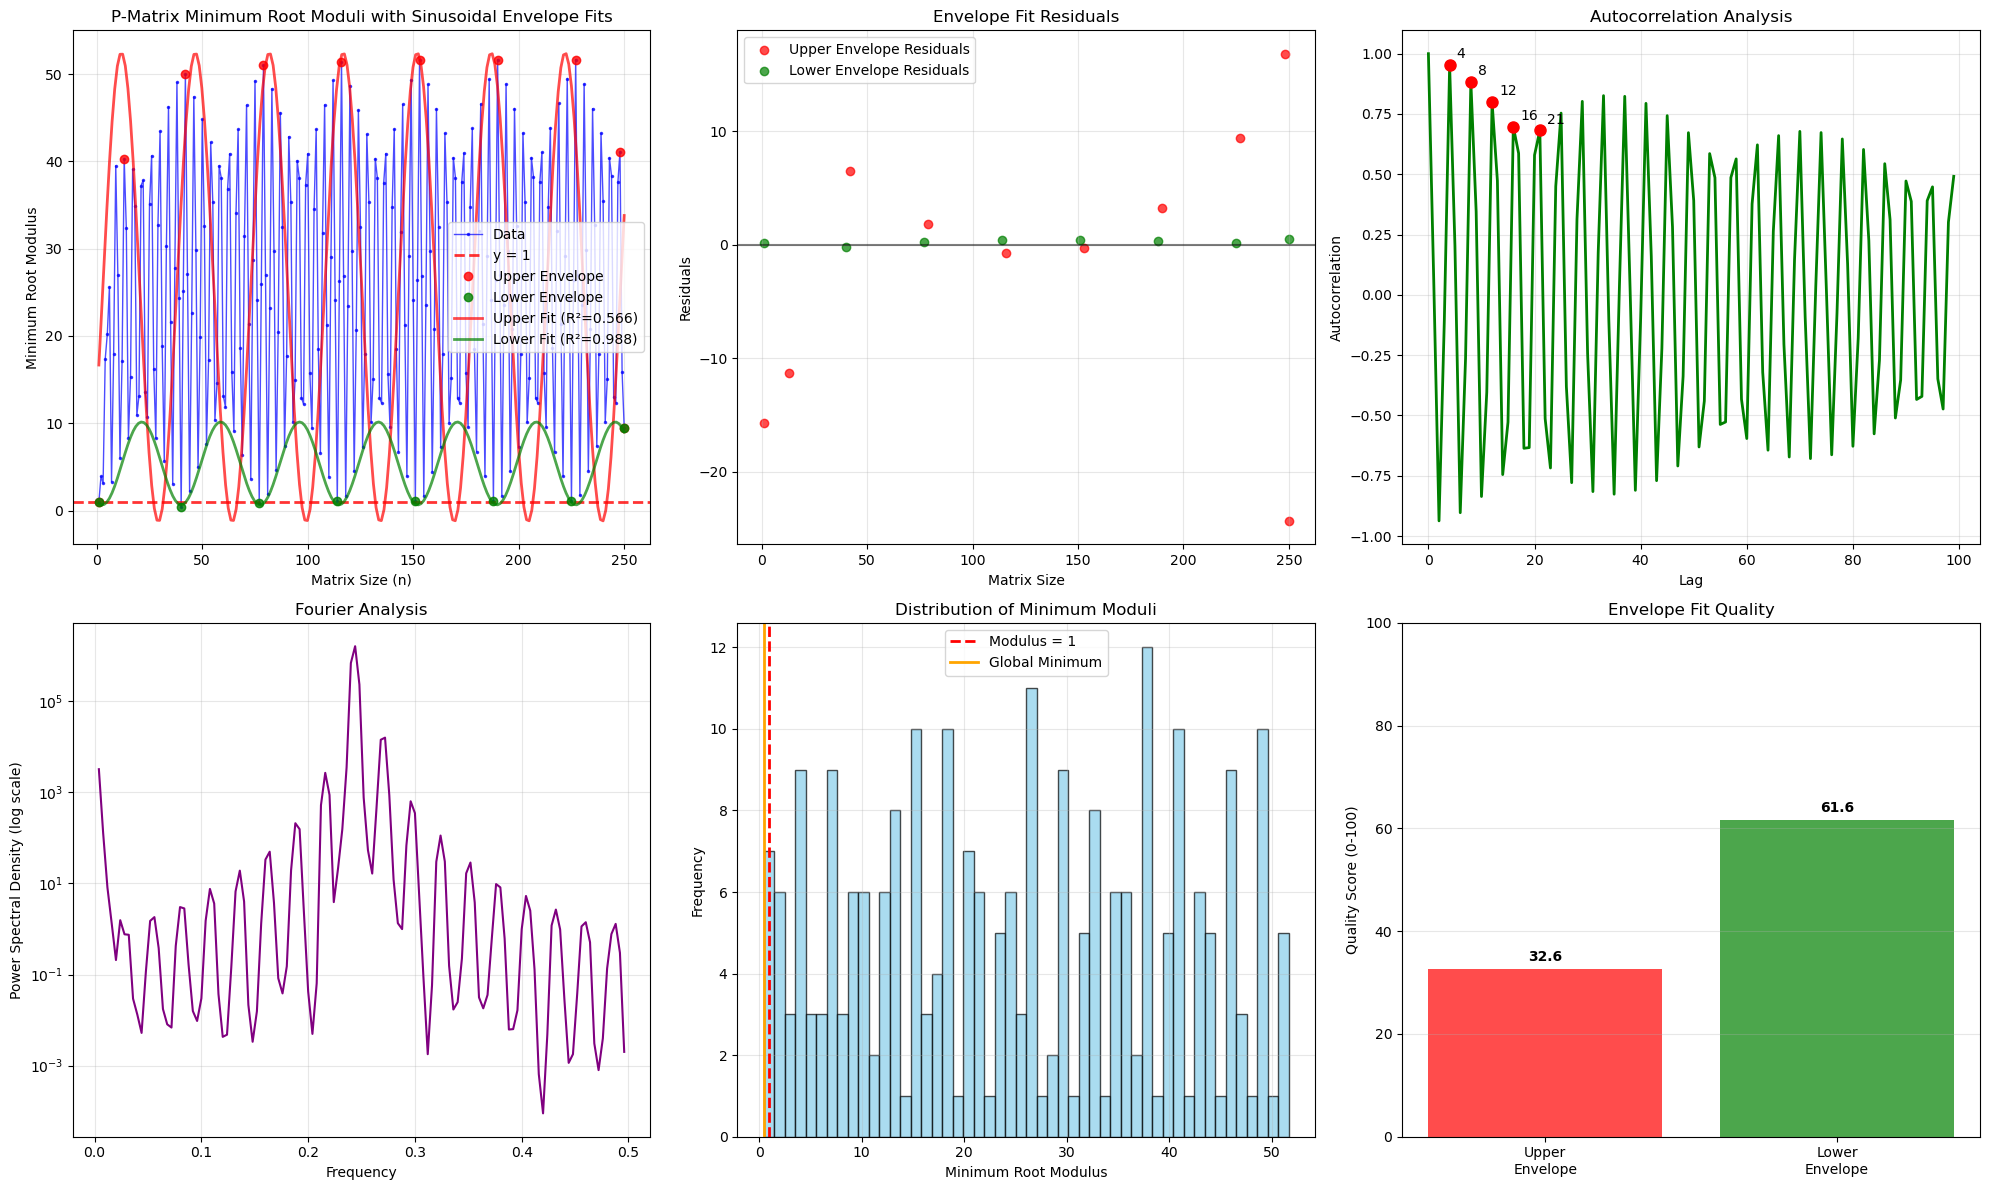

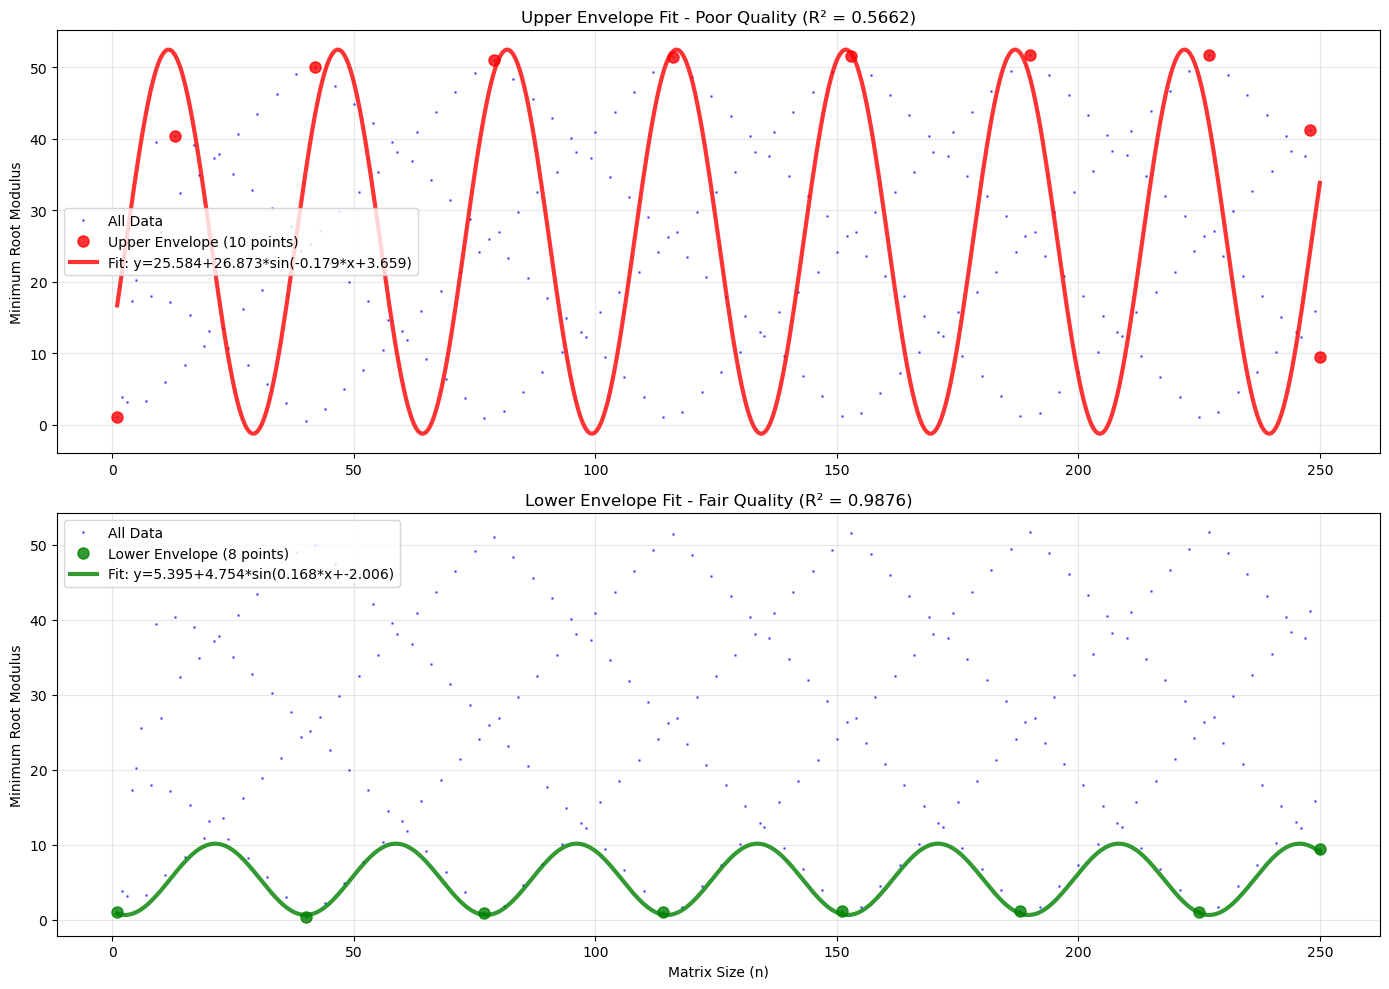

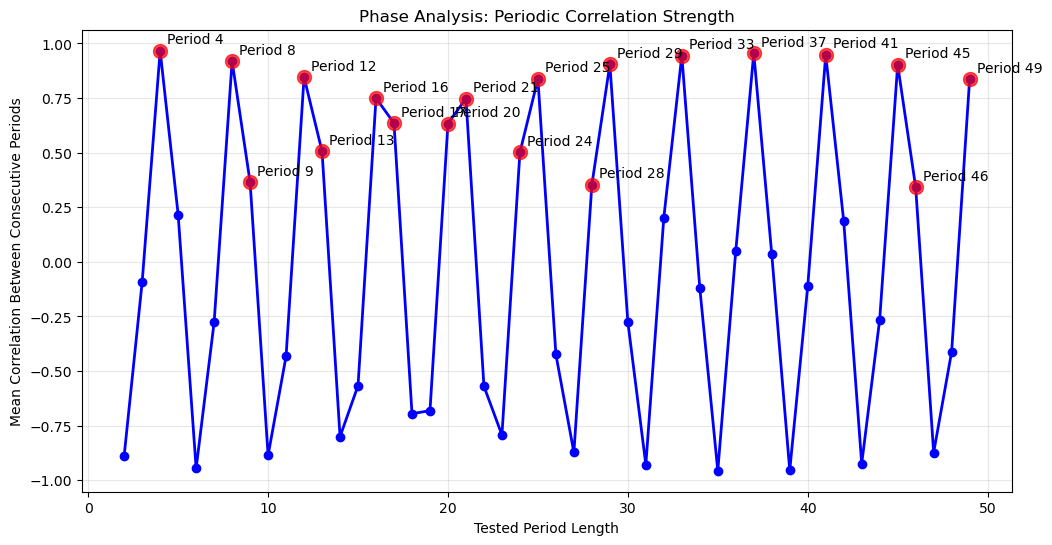

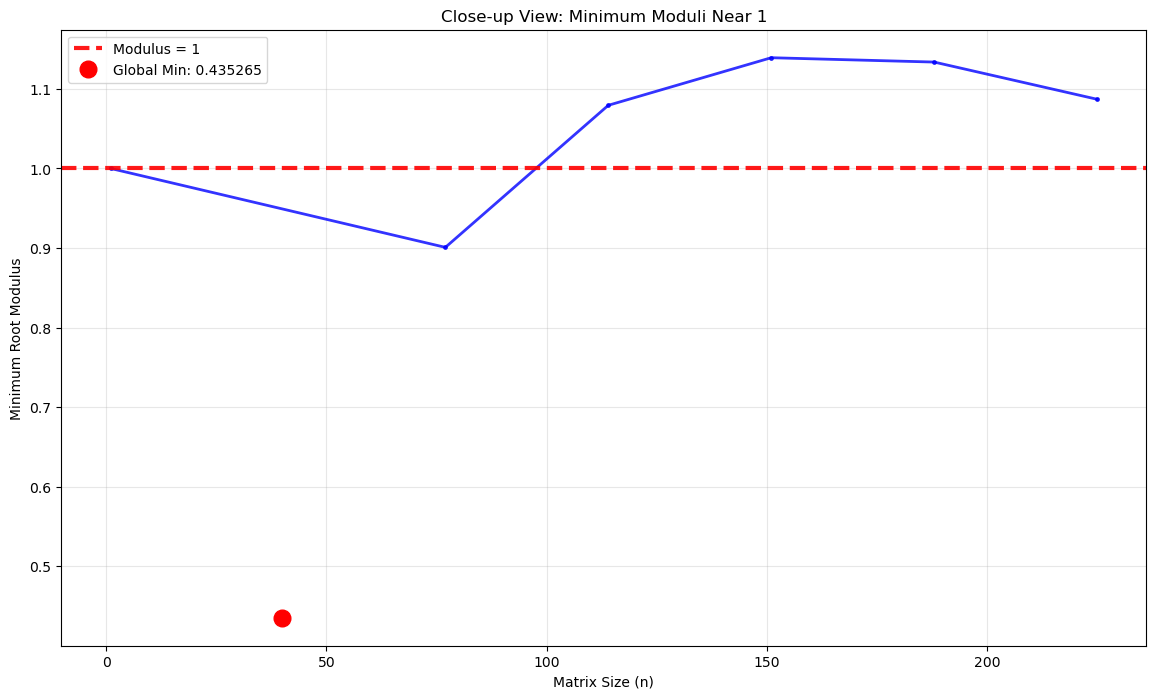


Generating analysis report...
Analysis report saved to: /Users/barrybrent/data/periodicity_analysis/PERIODICITY_AND_DISTANCE_ANALYSIS_REPORT.txt

ANALYSIS COMPLETE!
Global minimum modulus: 0.43526492 (matrix 40x40)
Distance from 1: 0.56473508
✗ DISTANCE CONJECTURE VIOLATED: 2 roots with modulus < 1
Detected periodicity evidence with periods: [np.int64(4), np.int64(8), 9, np.int64(12), 13]

ENVELOPE FITTING RESULTS:
Upper envelope: Poor fit (R² = 0.5662)
Lower envelope: Fair fit (R² = 0.9876)

Results saved to: /Users/barrybrent/data/periodicity_analysis/

✓ SUCCESS: Comprehensive analysis completed

SINUSOIDAL ENVELOPE FITTING SUMMARY:
--------------------------------------------------
Upper envelope fit: y = 25.5843 + 26.8729*sin(-0.1792*x + 3.6588)
  Quality: Poor (Score: 32.6/100)
  R-squared: 0.5662
  Mean relative error: 193.61%
Lower envelope fit: y = 5.3953 + 4.7537*sin(0.1679*x + -2.0055)
  Quality: Fair (Score: 61.6/100)
  R-squared: 0.9876
  Mean relative error: 26.45%
✓ Rep

In [20]:
# in view of block 6 below, block 5 is superflouous (Claude affirms.)
# Block 5: Report Generation and Main Execution Functions
# Run this after Block 4 - This is the final block

print("Starting Block 5: Report Generation and Main Execution Functions")
print("=" * 70)

# ============================================================================
# REPORT GENERATION
# ============================================================================

def generate_analysis_report(periodicity_results, distance_results, candidate_periods, output_dir, results_dir):
    """Generate comprehensive analysis report including envelope fitting results."""
    
    report_file = os.path.join(output_dir, 'PERIODICITY_AND_DISTANCE_ANALYSIS_REPORT.txt')
    
    with open(report_file, 'w') as f:
        f.write("P-MATRIX ROOT ANALYSIS: PERIODICITY, DISTANCE CONJECTURE, AND ENVELOPE FITTING\n")
        f.write("=" * 90 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Source Data Directory: {results_dir}\n")
        f.write(f"Total Matrices Analyzed: {distance_results['statistics']['total_matrices']}\n\n")
        
        # Distance Conjecture Analysis
        f.write("DISTANCE CONJECTURE ANALYSIS\n")
        f.write("-" * 40 + "\n")
        f.write("Conjecture: All characteristic polynomial roots have modulus > 1\n\n")
        
        global_min = distance_results['global_minimum']
        f.write(f"GLOBAL MINIMUM MODULUS:\n")
        f.write(f"  Value (high precision): {global_min['modulus_hp']}\n")
        f.write(f"  Value (float): {global_min['modulus_float']:.12f}\n")
        f.write(f"  Matrix size: {global_min['matrix_size']}x{global_min['matrix_size']}\n")
        f.write(f"  Distance from 1: {float(global_min['distance_from_one']):.12f}\n\n")
        
        stats = distance_results['statistics']
        f.write(f"STATISTICAL SUMMARY:\n")
        f.write(f"  Matrices with modulus < 1.0: {stats['num_below_1']}\n")
        f.write(f"  Matrices with modulus < 1.1: {stats['num_below_1_1']}\n")
        f.write(f"  Matrices with modulus < 1.01: {stats['num_below_1_01']}\n")
        f.write(f"  Mean modulus: {stats['mean_modulus']:.6f}\n")
        f.write(f"  Standard deviation: {stats['std_modulus']:.6f}\n\n")
        
        if stats['num_below_1'] == 0:
            f.write("✓ CONJECTURE SUPPORTED: No roots found with modulus < 1\n")
        else:
            f.write(f"✗ CONJECTURE VIOLATED: {stats['num_below_1']} roots found with modulus < 1\n")
        
        f.write(f"\nCLOSEST APPROACHES TO MODULUS = 1:\n")
        f.write(f"{'Matrix Size':<12} {'Modulus (12 digits)':<18} {'Distance from 1':<15}\n")
        f.write("-" * 50 + "\n")
        
        for i, call in enumerate(distance_results['close_calls'][:10]):
            f.write(f"{call['matrix_size']:<12} {call['modulus_float']:<18.12f} {float(call['distance_from_one']):<15.12f}\n")
        
        # Envelope Fitting Analysis
        f.write("\n\nSINUSOIDAL ENVELOPE FITTING ANALYSIS\n")
        f.write("-" * 50 + "\n")
        f.write("Function form: y = a + b * sin(c * x + d)\n")
        f.write("where a = vertical offset, b = amplitude, c = frequency, d = phase shift\n\n")
        
        envelope_data = periodicity_results.get('envelope_analysis', {})
        if envelope_data:
            upper_fit = envelope_data.get('upper_fit', {})
            lower_fit = envelope_data.get('lower_fit', {})
            
            f.write("UPPER ENVELOPE FITTING:\n")
            if upper_fit.get('params') is not None:
                params = upper_fit['params']
                info = upper_fit['info']
                f.write(f"  Function: y = {params[0]:.6f} + {params[1]:.6f} * sin({params[2]:.6f} * x + {params[3]:.6f})\n")
                f.write(f"  Quality Category: {info.get('quality_category', 'Unknown')}\n")
                f.write(f"  Quality Score: {info.get('quality_score', 0):.1f}/100\n")
                f.write(f"  R-squared: {info.get('r_squared', 0):.6f}\n")
                f.write(f"  RMSE: {info.get('rmse', 0):.8f}\n")
                f.write(f"  Mean Relative Error: {info.get('mean_relative_error', 0):.3f}%\n")
                f.write(f"  Max Relative Error: {info.get('max_relative_error', 0):.3f}%\n")
                f.write(f"  Data Points Used: {info.get('n_points', 0)}\n\n")
                
                # Include detailed explanation
                if 'quality_explanation' in info:
                    f.write("  DETAILED QUALITY ASSESSMENT:\n")
                    explanation_lines = info['quality_explanation'].split('\n')
                    for line in explanation_lines:
                        if line.strip():
                            f.write(f"  {line}\n")
                    f.write("\n")
            else:
                error_msg = upper_fit.get('info', {}).get('error', 'Unknown error')
                f.write(f"  Upper envelope fitting failed: {error_msg}\n\n")
            
            f.write("LOWER ENVELOPE FITTING:\n")
            if lower_fit.get('params') is not None:
                params = lower_fit['params']
                info = lower_fit['info']
                f.write(f"  Function: y = {params[0]:.6f} + {params[1]:.6f} * sin({params[2]:.6f} * x + {params[3]:.6f})\n")
                f.write(f"  Quality Category: {info.get('quality_category', 'Unknown')}\n")
                f.write(f"  Quality Score: {info.get('quality_score', 0):.1f}/100\n")
                f.write(f"  R-squared: {info.get('r_squared', 0):.6f}\n")
                f.write(f"  RMSE: {info.get('rmse', 0):.8f}\n")
                f.write(f"  Mean Relative Error: {info.get('mean_relative_error', 0):.3f}%\n")
                f.write(f"  Max Relative Error: {info.get('max_relative_error', 0):.3f}%\n")
                f.write(f"  Data Points Used: {info.get('n_points', 0)}\n\n")
                
                # Include detailed explanation
                if 'quality_explanation' in info:
                    f.write("  DETAILED QUALITY ASSESSMENT:\n")
                    explanation_lines = info['quality_explanation'].split('\n')
                    for line in explanation_lines:
                        if line.strip():
                            f.write(f"  {line}\n")
                    f.write("\n")
            else:
                error_msg = lower_fit.get('info', {}).get('error', 'Unknown error')
                f.write(f"  Lower envelope fitting failed: {error_msg}\n\n")
            
            # Envelope detection summary
            upper_env = envelope_data.get('upper_envelope', ([], []))
            lower_env = envelope_data.get('lower_envelope', ([], []))
            f.write(f"ENVELOPE DETECTION SUMMARY:\n")
            f.write(f"  Upper envelope points: {len(upper_env[0])}\n")
            f.write(f"  Lower envelope points: {len(lower_env[0])}\n")
            f.write(f"  Detection window size: {ENVELOPE_WINDOW}\n\n")
        
        # Periodicity Analysis
        f.write("PERIODICITY ANALYSIS\n")
        f.write("-" * 40 + "\n")
        
        f.write(f"CANDIDATE APPROXIMATE PERIODS: {candidate_periods}\n\n")
        
        if 'autocorr_peaks' in periodicity_results:
            f.write(f"AUTOCORRELATION PEAKS (lags): {list(periodicity_results['autocorr_peaks'][:10])}\n")
        
        if 'dominant_periods' in periodicity_results:
            periods = periodicity_results['dominant_periods']
            f.write(f"FOURIER ANALYSIS PERIODS: {[f'{p:.2f}' for p in periods[:5]]}\n")
        
        if 'phase_analysis' in periodicity_results:
            phase_data = periodicity_results['phase_analysis']
            strong_periods = [(p, data['mean_correlation']) for p, data in phase_data.items() 
                            if data['mean_correlation'] > 0.3]
            strong_periods.sort(key=lambda x: x[1], reverse=True)
            f.write(f"STRONG PHASE CORRELATIONS:\n")
            for period, corr in strong_periods[:10]:
                f.write(f"  Period {period}: correlation = {corr:.4f}\n")
        
        # Sliding window analysis
        if 'sliding_correlations' in periodicity_results:
            f.write(f"\nSLIDING WINDOW CORRELATIONS:\n")
            for window, corrs in periodicity_results['sliding_correlations'].items():
                if len(corrs) > 0:
                    f.write(f"  Window size {window}: mean = {np.mean(corrs):.4f}, std = {np.std(corrs):.4f}\n")
        
        # Conclusions
        f.write("\n\nCONCLUSIONS\n")
        f.write("-" * 40 + "\n")
        
        if len(candidate_periods) > 0:
            f.write(f"• Evidence of approximate periodicity with periods: {candidate_periods[:5]}\n")
        else:
            f.write("• No strong evidence of periodic behavior detected\n")
        
        if stats['num_below_1'] == 0:
            f.write(f"• Distance conjecture holds: minimum modulus = {global_min['modulus_float']:.6f} > 1\n")
        else:
            f.write(f"• Distance conjecture fails: {stats['num_below_1']} roots with modulus < 1\n")
        
        f.write(f"• Closest approach to unit circle: distance = {float(global_min['distance_from_one']):.8f}\n")
        
        # Envelope fitting conclusions
        if envelope_data:
            upper_success = envelope_data.get('upper_fit', {}).get('params') is not None
            lower_success = envelope_data.get('lower_fit', {}).get('params') is not None
            
            if upper_success or lower_success:
                f.write("• Sinusoidal envelope fitting results:\n")
                if upper_success:
                    upper_quality = envelope_data['upper_fit']['info'].get('quality_category', 'Unknown')
                    f.write(f"  - Upper envelope: {upper_quality} fit quality\n")
                if lower_success:
                    lower_quality = envelope_data['lower_fit']['info'].get('quality_category', 'Unknown')
                    f.write(f"  - Lower envelope: {lower_quality} fit quality\n")
            else:
                f.write("• Sinusoidal envelope fitting was unsuccessful\n")
        
        if global_min['modulus_float'] < 1.01:
            f.write("• WARNING: Global minimum very close to 1 - may need higher precision analysis\n")

    print(f"Analysis report saved to: {report_file}")

# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def run_comprehensive_analysis(base_dir, output_dir):
    """Run complete periodicity and distance analysis with automatic directory detection."""
    
    print("STARTING COMPREHENSIVE P-MATRIX ANALYSIS")
    print("=" * 80)
    
    # Automatically find the most recent P-matrix results directory
    print("Searching for P-matrix results...")
    results_dir = find_latest_pmatrix_results(base_dir)
    
    if results_dir is None:
        print("❌ Could not find P-matrix results directory")
        print(f"Expected directories with pattern: *_pmatrix_*")
        print(f"Search location: {base_dir}")
        print("\nPlease ensure you have:")
        print("1. Run the P-matrix analysis tool first")
        print("2. Set the correct BASE_DATA_DIR path")
        return None, None
    
    # Verify the directory contains valid data
    if not verify_results_directory(results_dir):
        print("❌ Results directory is invalid or incomplete")
        return None, None
    
    print(f"✓ Using results directory: {results_dir}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load data
    print("\nLoading analysis results...")
    data = load_analysis_results(results_dir)
    if data is None:
        return None, None
    
    detailed_data = extract_detailed_root_data(results_dir)
    if not detailed_data:
        print("Could not load detailed root data")
        return None, None
    
    # Periodicity analysis
    print("\nAnalyzing periodicity patterns...")
    periodicity_results = analyze_periodicity_patterns(data['moduli_values'], data['n_values'])
    
    candidate_periods = detect_approximate_periods(periodicity_results)
    print(f"Detected candidate periods: {candidate_periods}")
    
    # Distance conjecture analysis
    print("\nAnalyzing distance conjecture...")
    distance_results = analyze_distance_conjecture(detailed_data)
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    create_comprehensive_plots(periodicity_results, distance_results, output_dir)
    
    # Generate report
    print("\nGenerating analysis report...")
    generate_analysis_report(periodicity_results, distance_results, candidate_periods, output_dir, results_dir)
    
    # Summary output
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE!")
    print("=" * 80)
    
    global_min = distance_results['global_minimum']
    print(f"Global minimum modulus: {global_min['modulus_float']:.8f} (matrix {global_min['matrix_size']}x{global_min['matrix_size']})")
    print(f"Distance from 1: {float(global_min['distance_from_one']):.8f}")
    
    if distance_results['statistics']['num_below_1'] == 0:
        print("✓ DISTANCE CONJECTURE SUPPORTED: All roots have modulus > 1")
    else:
        print(f"✗ DISTANCE CONJECTURE VIOLATED: {distance_results['statistics']['num_below_1']} roots with modulus < 1")
    
    if candidate_periods:
        print(f"Detected periodicity evidence with periods: {candidate_periods[:5]}")
    else:
        print("No strong periodicity detected")
    
    # Print envelope fitting results
    envelope_data = periodicity_results.get('envelope_analysis', {})
    if envelope_data:
        upper_fit = envelope_data.get('upper_fit', {})
        lower_fit = envelope_data.get('lower_fit', {})
        
        print(f"\nENVELOPE FITTING RESULTS:")
        if upper_fit.get('params') is not None:
            upper_info = upper_fit['info']
            print(f"Upper envelope: {upper_info.get('quality_category', 'Unknown')} fit "
                  f"(R² = {upper_info.get('r_squared', 0):.4f})")
        
        if lower_fit.get('params') is not None:
            lower_info = lower_fit['info']
            print(f"Lower envelope: {lower_info.get('quality_category', 'Unknown')} fit "
                  f"(R² = {lower_info.get('r_squared', 0):.4f})")
    
    print(f"\nResults saved to: {output_dir}")
    
    return periodicity_results, distance_results

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("P-MATRIX PERIODICITY AND ENVELOPE ANALYSIS")
    print("=" * 80)
    print(f"Base data directory: {BASE_DATA_DIR}")
    print(f"Output directory: {OUTPUT_DIR}")
    print(f"Envelope window size: {ENVELOPE_WINDOW}")
    print("=" * 80)
    
    # Run the analysis with automatic directory detection
    periodicity_results, distance_results = run_comprehensive_analysis(
        BASE_DATA_DIR, 
        OUTPUT_DIR
    )
    
    if periodicity_results is not None and distance_results is not None:
        print("\n✓ SUCCESS: Comprehensive analysis completed")
        
        # Print envelope fitting summary if available
        envelope_data = periodicity_results.get('envelope_analysis', {})
        if envelope_data:
            print("\nSINUSOIDAL ENVELOPE FITTING SUMMARY:")
            print("-" * 50)
            
            upper_fit = envelope_data.get('upper_fit', {})
            if upper_fit.get('params') is not None:
                params = upper_fit['params']
                info = upper_fit['info']
                print(f"Upper envelope fit: y = {params[0]:.4f} + {params[1]:.4f}*sin({params[2]:.4f}*x + {params[3]:.4f})")
                print(f"  Quality: {info.get('quality_category', 'Unknown')} (Score: {info.get('quality_score', 0):.1f}/100)")
                print(f"  R-squared: {info.get('r_squared', 0):.4f}")
                print(f"  Mean relative error: {info.get('mean_relative_error', 0):.2f}%")
            
            lower_fit = envelope_data.get('lower_fit', {})
            if lower_fit.get('params') is not None:
                params = lower_fit['params']
                info = lower_fit['info']
                print(f"Lower envelope fit: y = {params[0]:.4f} + {params[1]:.4f}*sin({params[2]:.4f}*x + {params[3]:.4f})")
                print(f"  Quality: {info.get('quality_category', 'Unknown')} (Score: {info.get('quality_score', 0):.1f}/100)")
                print(f"  R-squared: {info.get('r_squared', 0):.4f}")
                print(f"  Mean relative error: {info.get('mean_relative_error', 0):.2f}%")
    else:
        print("\n❌ Analysis failed - check error messages above")

print("✓ Report generation function loaded:")
print("  - generate_analysis_report(): Creates comprehensive text report")
print("✓ Main execution function loaded:")
print("  - run_comprehensive_analysis(): Orchestrates the entire analysis")
print("✓ Execution section loaded - ready to run!")

print("\nBlock 5 complete: All functions loaded and ready to execute.")
print("You can now run the analysis by executing: run_comprehensive_analysis(BASE_DATA_DIR, OUTPUT_DIR)")
print("=" * 70)

Starting Block 6: Complete Analysis with Enhanced Violation Reporting
STARTING COMPLETE P-MATRIX ANALYSIS WITH VIOLATION DETAILS
Found 3 P-matrix result directories
Using most recent: run1sept25no1_pmatrix_20250906_021631
Found 250 individual matrix result files
✓ Using results directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250906_021631

Loading analysis results...
Loaded data for 250 matrices
Matrix sizes: 1 to 250
Extracted detailed data for 250 matrices

Analyzing periodicity patterns...
Computing autocorrelation...
Computing Fourier transform...
Detecting envelopes and fitting sinusoidal functions...
Computing sliding window correlations...
Computing phase analysis...
Detected candidate periods: [np.int64(4), np.int64(8), 9, np.int64(12), 13, np.int64(16), np.int64(21)]

Analyzing distance conjecture...
Analyzing distance conjecture...

Generating visualizations...


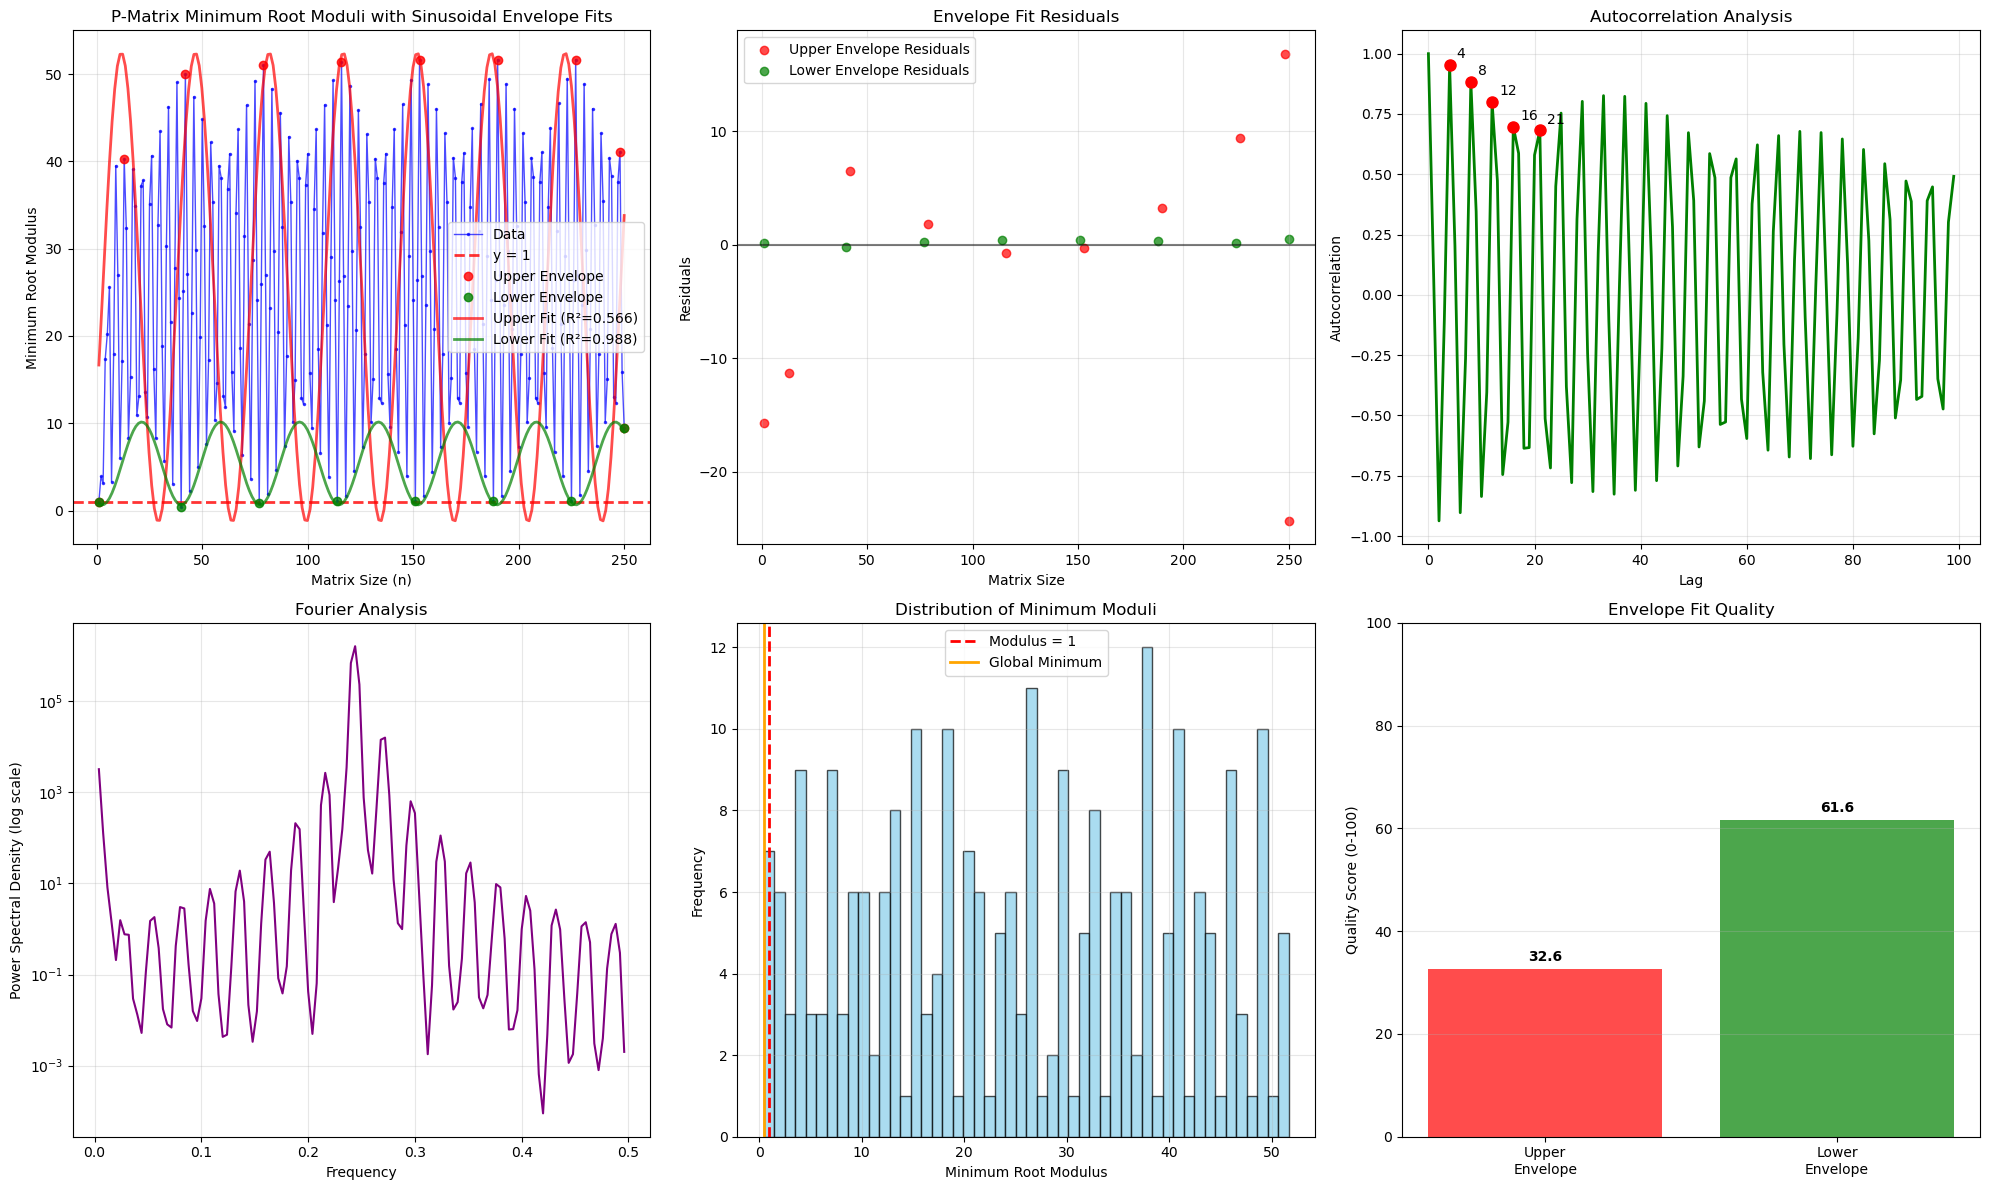

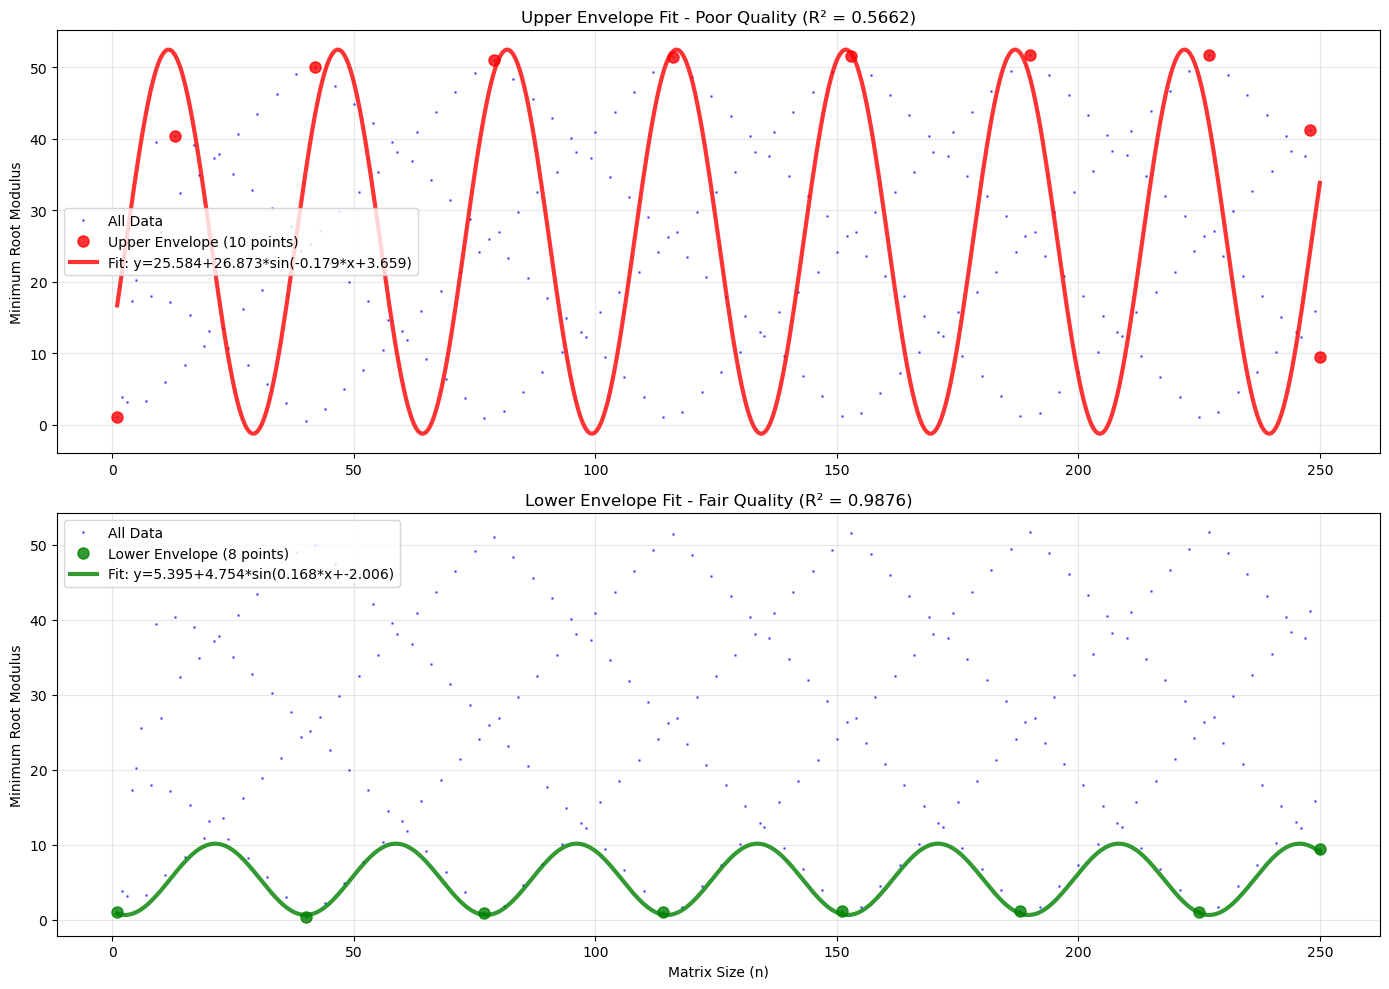

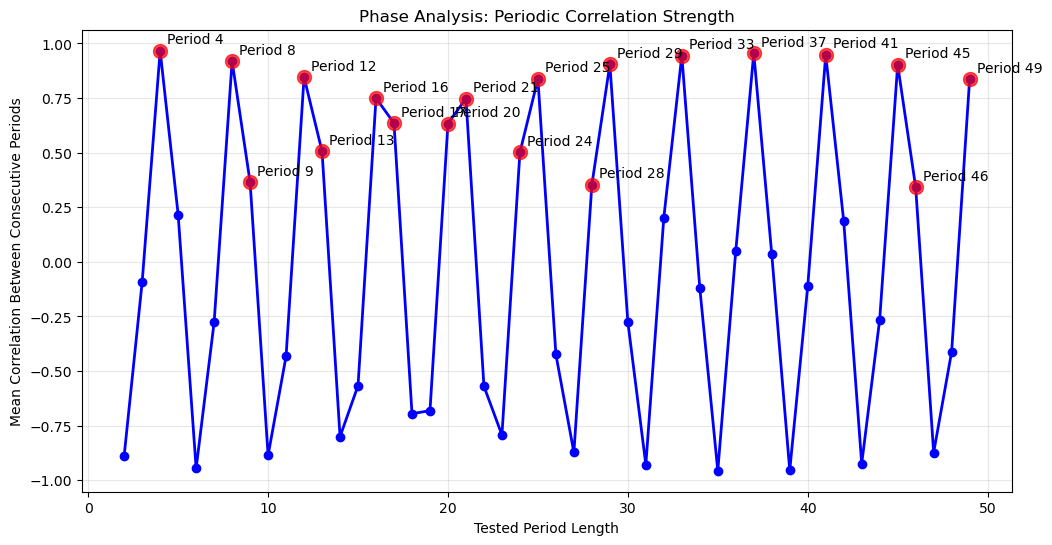

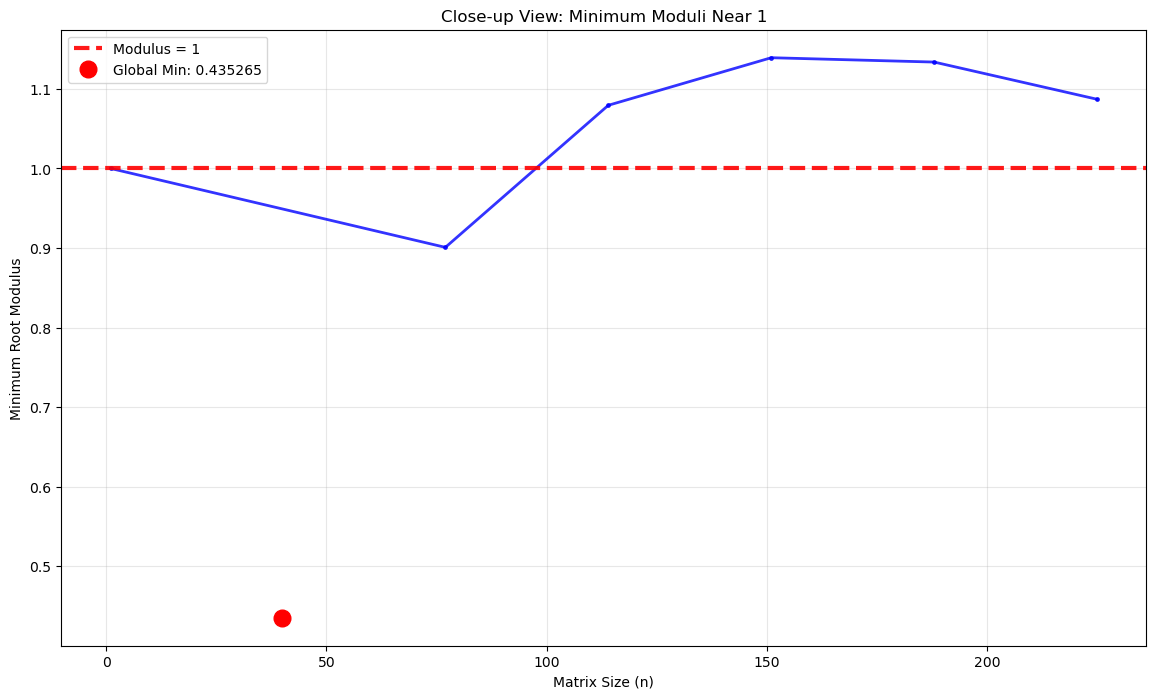


Generating enhanced report with violation details...
Enhanced analysis report saved to: /Users/barrybrent/data/periodicity_analysis/ENHANCED_PERIODICITY_AND_DISTANCE_ANALYSIS_REPORT.txt

COMPLETE ANALYSIS WITH VIOLATION DETAILS FINISHED!
Global minimum modulus: 0.43526492 (matrix 40x40)
✗ DISTANCE CONJECTURE VIOLATED: 2 roots with modulus < 1
✓ Detailed violation information saved to enhanced report
  Violation 1: Matrix 77x77, modulus = 0.90082350
  Violation 2: Matrix 40x40, modulus = 0.43526492
Detected periodicity evidence with periods: [np.int64(4), np.int64(8), 9, np.int64(12), 13]

ENVELOPE FITTING RESULTS:
Upper envelope: y = 25.5843 + 26.8729*sin(-0.1792*x + 3.6588)
  Quality: Poor (R² = 0.5662)
Lower envelope: y = 5.3953 + 4.7537*sin(0.1679*x + -2.0055)
  Quality: Fair (R² = 0.9876)

Results saved to: /Users/barrybrent/data/periodicity_analysis/
Enhanced report: /Users/barrybrent/data/periodicity_analysis//ENHANCED_PERIODICITY_AND_DISTANCE_ANALYSIS_REPORT.txt

Block 6 comple

In [21]:
# Block 6: Complete Analysis with Enhanced Violation Reporting
# Run this after Blocks 1-5 to get the complete analysis with detailed conjecture violations

print("Starting Block 6: Complete Analysis with Enhanced Violation Reporting")
print("=" * 80)

def generate_enhanced_analysis_report(periodicity_results, distance_results, candidate_periods, output_dir, results_dir):
    """Generate comprehensive analysis report including detailed conjecture violations."""
    
    report_file = os.path.join(output_dir, 'ENHANCED_PERIODICITY_AND_DISTANCE_ANALYSIS_REPORT.txt')
    
    with open(report_file, 'w') as f:
        f.write("P-MATRIX ROOT ANALYSIS: PERIODICITY, DISTANCE CONJECTURE, AND ENVELOPE FITTING\n")
        f.write("=" * 90 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Source Data Directory: {results_dir}\n")
        f.write(f"Total Matrices Analyzed: {distance_results['statistics']['total_matrices']}\n\n")
        
        # Distance Conjecture Analysis
        f.write("DISTANCE CONJECTURE ANALYSIS\n")
        f.write("-" * 40 + "\n")
        f.write("Conjecture: All characteristic polynomial roots have modulus > 1\n\n")
        
        global_min = distance_results['global_minimum']
        f.write(f"GLOBAL MINIMUM MODULUS:\n")
        f.write(f"  Value (high precision): {global_min['modulus_hp']}\n")
        f.write(f"  Value (float): {global_min['modulus_float']:.12f}\n")
        f.write(f"  Matrix size: {global_min['matrix_size']}x{global_min['matrix_size']}\n")
        f.write(f"  Distance from 1: {float(global_min['distance_from_one']):.12f}\n\n")
        
        stats = distance_results['statistics']
        f.write(f"STATISTICAL SUMMARY:\n")
        f.write(f"  Matrices with modulus < 1.0: {stats['num_below_1']}\n")
        f.write(f"  Matrices with modulus < 1.1: {stats['num_below_1_1']}\n")
        f.write(f"  Matrices with modulus < 1.01: {stats['num_below_1_01']}\n")
        f.write(f"  Mean modulus: {stats['mean_modulus']:.6f}\n")
        f.write(f"  Standard deviation: {stats['std_modulus']:.6f}\n\n")
        
        if stats['num_below_1'] == 0:
            f.write("✓ CONJECTURE SUPPORTED: No roots found with modulus < 1\n")
        else:
            f.write(f"✗ CONJECTURE VIOLATED: {stats['num_below_1']} roots found with modulus < 1\n\n")
            
            # DETAILED VIOLATION INFORMATION
            f.write("DETAILED CONJECTURE VIOLATIONS:\n")
            f.write("=" * 60 + "\n")
            
            # Find all violations (modulus < 1.0)
            violations = [call for call in distance_results['close_calls'] if call['modulus_float'] < 1.0]
            
            for i, violation in enumerate(violations, 1):
                matrix_size = violation['matrix_size']
                f.write(f"\nVIOLATION #{i}:\n")
                f.write(f"Matrix Index: {matrix_size}\n")
                f.write(f"Matrix Size: {matrix_size}x{matrix_size}\n")
                f.write(f"Minimum Root Modulus: {violation['modulus_float']:.12f}\n")
                f.write(f"Distance from 1: {float(violation['distance_from_one']):.12f}\n")
                
                # Load the detailed data for this matrix
                tuple_file = os.path.join(results_dir, f"tuple_{matrix_size}x{matrix_size}.txt")
                poly_file = os.path.join(results_dir, f"polynomial_{matrix_size}x{matrix_size}.txt")
                
                if os.path.exists(tuple_file):
                    try:
                        with open(tuple_file, 'r') as tf:
                            line = tf.readline().strip()
                            data_tuple = eval(line)
                            n, poly_str, root_str, modulus_str, modulus_float = data_tuple
                            
                            f.write(f"Violating Root: {root_str}\n")
                            f.write(f"Root Modulus (high precision): {modulus_str}\n")
                            
                            # Handle polynomial length
                            if len(poly_str) > 1000:
                                # Show first part and indicate truncation
                                first_part = poly_str[:500]
                                last_part = poly_str[-200:]
                                f.write(f"Characteristic Polynomial: {first_part}...[middle truncated]...{last_part}\n")
                            else:
                                f.write(f"Characteristic Polynomial: {poly_str}\n")
                            
                    except Exception as e:
                        f.write(f"Error reading violation details: {e}\n")
                
                f.write("-" * 60 + "\n")
        
        # Envelope Fitting Analysis
        f.write("\n\nSINUSOIDAL ENVELOPE FITTING ANALYSIS\n")
        f.write("-" * 50 + "\n")
        f.write("Function form: y = a + b * sin(c * x + d)\n")
        f.write("where a = vertical offset, b = amplitude, c = frequency, d = phase shift\n\n")
        
        envelope_data = periodicity_results.get('envelope_analysis', {})
        if envelope_data:
            upper_fit = envelope_data.get('upper_fit', {})
            lower_fit = envelope_data.get('lower_fit', {})
            
            f.write("UPPER ENVELOPE FITTING:\n")
            if upper_fit.get('params') is not None:
                params = upper_fit['params']
                info = upper_fit['info']
                f.write(f"  Function: y = {params[0]:.6f} + {params[1]:.6f} * sin({params[2]:.6f} * x + {params[3]:.6f})\n")
                f.write(f"  Quality Category: {info.get('quality_category', 'Unknown')}\n")
                f.write(f"  Quality Score: {info.get('quality_score', 0):.1f}/100\n")
                f.write(f"  R-squared: {info.get('r_squared', 0):.6f}\n")
                f.write(f"  RMSE: {info.get('rmse', 0):.8f}\n")
                f.write(f"  Mean Relative Error: {info.get('mean_relative_error', 0):.3f}%\n")
                f.write(f"  Data Points Used: {info.get('n_points', 0)}\n\n")
            else:
                error_msg = upper_fit.get('info', {}).get('error', 'Unknown error')
                f.write(f"  Upper envelope fitting failed: {error_msg}\n\n")
            
            f.write("LOWER ENVELOPE FITTING:\n")
            if lower_fit.get('params') is not None:
                params = lower_fit['params']
                info = lower_fit['info']
                f.write(f"  Function: y = {params[0]:.6f} + {params[1]:.6f} * sin({params[2]:.6f} * x + {params[3]:.6f})\n")
                f.write(f"  Quality Category: {info.get('quality_category', 'Unknown')}\n")
                f.write(f"  Quality Score: {info.get('quality_score', 0):.1f}/100\n")
                f.write(f"  R-squared: {info.get('r_squared', 0):.6f}\n")
                f.write(f"  RMSE: {info.get('rmse', 0):.8f}\n")
                f.write(f"  Mean Relative Error: {info.get('mean_relative_error', 0):.3f}%\n")
                f.write(f"  Data Points Used: {info.get('n_points', 0)}\n\n")
            else:
                error_msg = lower_fit.get('info', {}).get('error', 'Unknown error')
                f.write(f"  Lower envelope fitting failed: {error_msg}\n\n")
        
        # Periodicity Analysis
        f.write("PERIODICITY ANALYSIS\n")
        f.write("-" * 40 + "\n")
        f.write(f"CANDIDATE APPROXIMATE PERIODS: {candidate_periods}\n\n")
        
        if 'autocorr_peaks' in periodicity_results:
            f.write(f"AUTOCORRELATION PEAKS (lags): {list(periodicity_results['autocorr_peaks'][:10])}\n")
        
        if 'dominant_periods' in periodicity_results:
            periods = periodicity_results['dominant_periods']
            f.write(f"FOURIER ANALYSIS PERIODS: {[f'{p:.2f}' for p in periods[:5]]}\n")
        
        # Conclusions
        f.write("\n\nCONCLUSIONS\n")
        f.write("-" * 40 + "\n")
        
        if len(candidate_periods) > 0:
            f.write(f"• Evidence of approximate periodicity with periods: {candidate_periods[:5]}\n")
        else:
            f.write("• No strong evidence of periodic behavior detected\n")
        
        if stats['num_below_1'] == 0:
            f.write(f"• Distance conjecture holds: minimum modulus = {global_min['modulus_float']:.6f} > 1\n")
        else:
            f.write(f"• Distance conjecture fails: {stats['num_below_1']} specific violations documented above\n")
        
        f.write(f"• Closest approach to unit circle: distance = {float(global_min['distance_from_one']):.8f}\n")

    print(f"Enhanced analysis report saved to: {report_file}")

def run_complete_analysis_with_violations():
    """Run the complete analysis and generate enhanced report with violation details."""
    
    print("STARTING COMPLETE P-MATRIX ANALYSIS WITH VIOLATION DETAILS")
    print("=" * 80)
    
    # Find results directory
    results_dir = find_latest_pmatrix_results(BASE_DATA_DIR)
    if not results_dir:
        print("❌ Could not find P-matrix results directory")
        return
    
    if not verify_results_directory(results_dir):
        print("❌ Results directory is invalid or incomplete")
        return
    
    print(f"✓ Using results directory: {results_dir}")
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load data
    print("\nLoading analysis results...")
    data = load_analysis_results(results_dir)
    if data is None:
        return
    
    detailed_data = extract_detailed_root_data(results_dir)
    if not detailed_data:
        print("Could not load detailed root data")
        return
    
    # Run all analyses
    print("\nAnalyzing periodicity patterns...")
    periodicity_results = analyze_periodicity_patterns(data['moduli_values'], data['n_values'])
    
    candidate_periods = detect_approximate_periods(periodicity_results)
    print(f"Detected candidate periods: {candidate_periods}")
    
    print("\nAnalyzing distance conjecture...")
    distance_results = analyze_distance_conjecture(detailed_data)
    
    print("\nGenerating visualizations...")
    create_comprehensive_plots(periodicity_results, distance_results, OUTPUT_DIR)
    
    print("\nGenerating enhanced report with violation details...")
    generate_enhanced_analysis_report(periodicity_results, distance_results, candidate_periods, OUTPUT_DIR, results_dir)
    
    # Summary output
    print("\n" + "=" * 80)
    print("COMPLETE ANALYSIS WITH VIOLATION DETAILS FINISHED!")
    print("=" * 80)
    
    global_min = distance_results['global_minimum']
    print(f"Global minimum modulus: {global_min['modulus_float']:.8f} (matrix {global_min['matrix_size']}x{global_min['matrix_size']})")
    
    if distance_results['statistics']['num_below_1'] == 0:
        print("✓ DISTANCE CONJECTURE SUPPORTED: All roots have modulus > 1")
    else:
        violations_count = distance_results['statistics']['num_below_1']
        print(f"✗ DISTANCE CONJECTURE VIOLATED: {violations_count} roots with modulus < 1")
        print("✓ Detailed violation information saved to enhanced report")
        
        # Show violations summary
        violations = [call for call in distance_results['close_calls'] if call['modulus_float'] < 1.0]
        for i, violation in enumerate(violations, 1):
            print(f"  Violation {i}: Matrix {violation['matrix_size']}x{violation['matrix_size']}, modulus = {violation['modulus_float']:.8f}")
    
    if candidate_periods:
        print(f"Detected periodicity evidence with periods: {candidate_periods[:5]}")
    
    # Envelope fitting results
    envelope_data = periodicity_results.get('envelope_analysis', {})
    if envelope_data:
        upper_fit = envelope_data.get('upper_fit', {})
        lower_fit = envelope_data.get('lower_fit', {})
        
        print(f"\nENVELOPE FITTING RESULTS:")
        if upper_fit.get('params') is not None:
            upper_info = upper_fit['info']
            params = upper_fit['params']
            print(f"Upper envelope: y = {params[0]:.4f} + {params[1]:.4f}*sin({params[2]:.4f}*x + {params[3]:.4f})")
            print(f"  Quality: {upper_info.get('quality_category', 'Unknown')} (R² = {upper_info.get('r_squared', 0):.4f})")
        
        if lower_fit.get('params') is not None:
            lower_info = lower_fit['info']
            params = lower_fit['params']
            print(f"Lower envelope: y = {params[0]:.4f} + {params[1]:.4f}*sin({params[2]:.4f}*x + {params[3]:.4f})")
            print(f"  Quality: {lower_info.get('quality_category', 'Unknown')} (R² = {lower_info.get('r_squared', 0):.4f})")
    
    print(f"\nResults saved to: {OUTPUT_DIR}")
    print(f"Enhanced report: {OUTPUT_DIR}/ENHANCED_PERIODICITY_AND_DISTANCE_ANALYSIS_REPORT.txt")

# Execute the complete analysis
run_complete_analysis_with_violations()

print("\nBlock 6 complete: Enhanced analysis with detailed violation reporting finished!")
print("=" * 80)

Starting Block 7 Fixed: Multiple Harmonic Envelope Fitting
ANALYZING ENVELOPES WITH MULTIPLE HARMONICS
Found 3 P-matrix result directories
Using most recent: run1sept25no1_pmatrix_20250906_021631
Loaded data for 250 matrices
Matrix sizes: 1 to 250
Detecting envelopes...
Upper envelope: 10 points
Lower envelope: 8 points
Maximum harmonics for upper envelope: 3
Maximum harmonics for lower envelope: 2

--- FITTING WITH 1 HARMONIC(S) ---
Fitting upper envelope with 1 harmonics...
Upper envelope - 1 harmonics:
  Quality: Poor
  R²: 0.5662
  RMSE: 11.809499
  Mean rel. error: 193.60%
  Function: y = 25.5836 + 26.8737*sin(-0.1792*x + 3.6588)
Fitting lower envelope with 1 harmonics...
Lower envelope - 1 harmonics:
  Quality: Excellent
  R²: 0.9876
  RMSE: 0.314213
  Mean rel. error: 26.45%
  Function: y = 5.3948 + 4.7536*sin(0.1679*x + -2.0058)

--- FITTING WITH 2 HARMONIC(S) ---
Fitting upper envelope with 2 harmonics...
Upper envelope fitting failed: Insufficient data points for 2 harmonics.

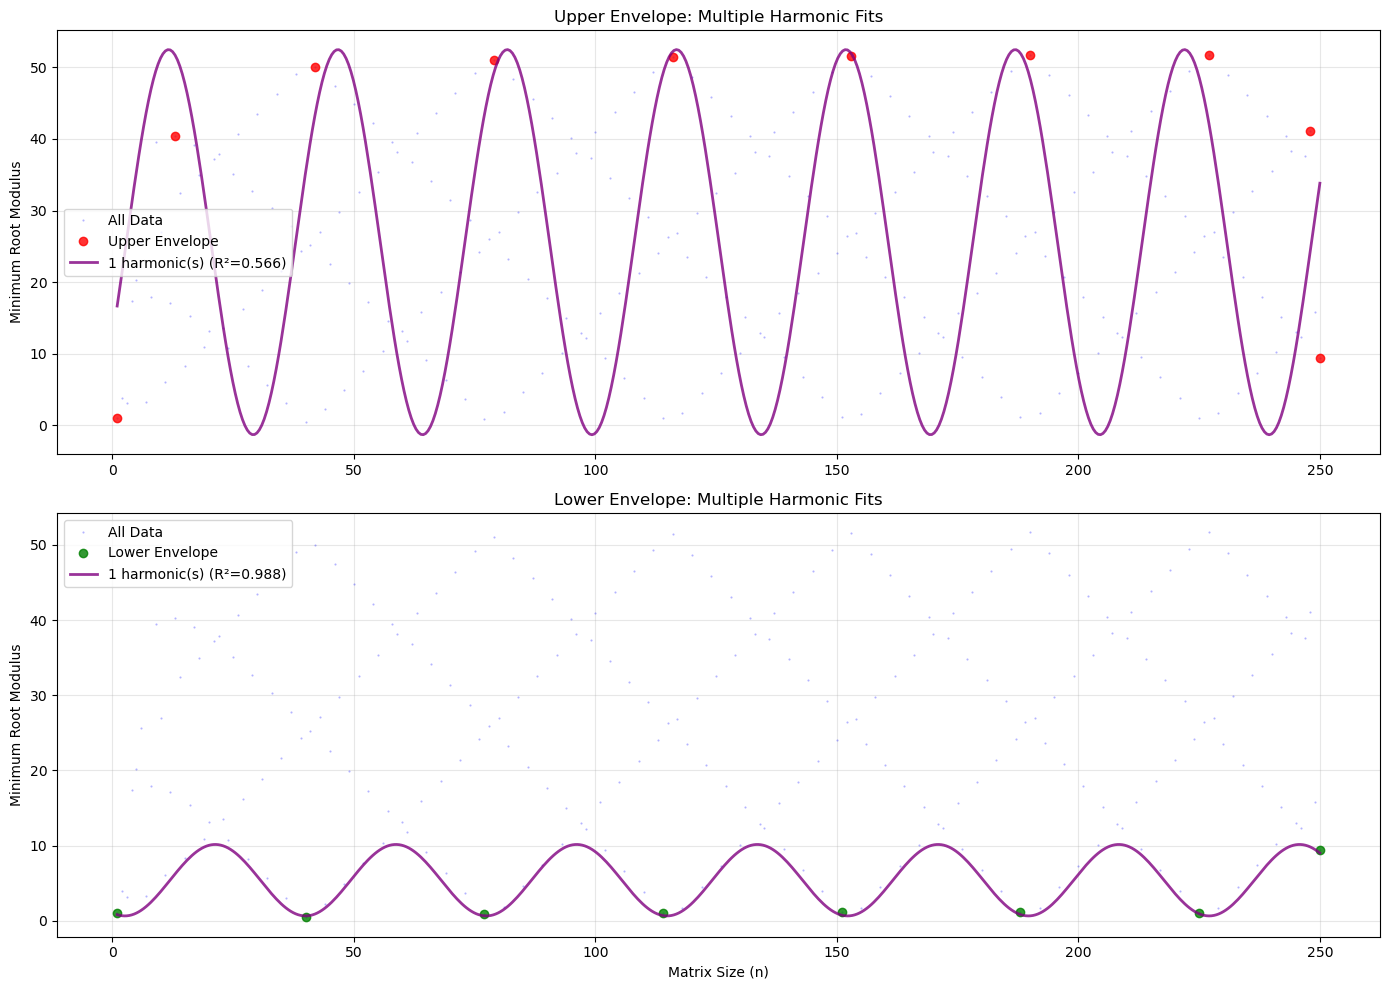


Comparison plot saved to: /Users/barrybrent/data/periodicity_analysis//multiple_harmonic_comparison.png

SUMMARY OF BEST FITS:
Best upper envelope fit: 1 harmonics (R² = 0.5662)
Best lower envelope fit: 1 harmonics (R² = 0.9876)

Block 7 Fixed complete: Multiple harmonic envelope fitting analysis finished!


In [23]:
# Block 7 Fixed: Multiple Harmonic Envelope Fitting
# Run this after previous blocks to try more flexible sinusoidal fits

print("Starting Block 7 Fixed: Multiple Harmonic Envelope Fitting")
print("=" * 70)

def multiple_harmonic_function(x, *params):
    """
    Multiple harmonic function: y = a + b₁*sin(c₁*x + d₁) + b₂*sin(c₂*x + d₂) + ...
    
    Parameters come in groups of 3: (amplitude, frequency, phase) for each harmonic
    Plus one offset parameter at the beginning
    """
    if len(params) < 4:
        return np.zeros_like(x, dtype=float)
    
    # Ensure all inputs are float arrays
    x = np.asarray(x, dtype=float)
    a = float(params[0])  # offset
    result = np.full_like(x, a, dtype=float)
    
    # Process harmonics in groups of 3 (amplitude, frequency, phase)
    for i in range(1, len(params), 3):
        if i + 2 < len(params):
            b = float(params[i])     # amplitude
            c = float(params[i+1])   # frequency
            d = float(params[i+2])   # phase
            result = result + b * np.sin(c * x + d)
    
    return result

def fit_multiple_harmonic_envelope(x_data, y_data, num_harmonics=2):
    """
    Fit multiple harmonic function to envelope data.
    
    Parameters:
    - x_data: array of x coordinates
    - y_data: array of y coordinates  
    - num_harmonics: number of sinusoidal components to fit
    
    Returns:
    - params: fitted parameters
    - fit_info: dictionary with fitting statistics
    """
    
    # Convert to float arrays to avoid casting issues
    x_array = np.asarray(x_data, dtype=float)
    y_array = np.asarray(y_data, dtype=float)
    
    # Check if we have enough data points (need at least 2 points per parameter)
    num_params = 1 + 3 * num_harmonics  # offset + 3 params per harmonic
    min_points_needed = 2 * num_params
    
    if len(x_data) < min_points_needed:
        return None, {
            'error': f'Insufficient data points for {num_harmonics} harmonics. Need at least {min_points_needed}, got {len(x_data)}',
            'success': False
        }
    
    # Normalize x-data for better numerical stability
    x_min, x_max = x_array.min(), x_array.max()
    if x_max > x_min:
        x_norm = 2 * np.pi * (x_array - x_min) / (x_max - x_min)
    else:
        x_norm = x_array
    
    # Initial parameter estimates
    a_init = float(np.mean(y_array))  # offset
    amplitude_scale = float(np.max(y_array) - np.min(y_array)) / (2 * num_harmonics)
    
    # Build initial guess: offset + (amplitude, frequency, phase) for each harmonic
    initial_guess = [a_init]
    bounds_lower = [float(y_array.min()) - amplitude_scale]
    bounds_upper = [float(y_array.max()) + amplitude_scale]
    
    for i in range(num_harmonics):
        # Each harmonic gets: amplitude, frequency, phase
        initial_guess.extend([
            amplitude_scale / (i + 1),  # decreasing amplitudes
            2 * np.pi * (i + 1) / len(x_array),  # different frequencies
            0.0  # phase
        ])
        
        bounds_lower.extend([
            -10 * amplitude_scale,  # amplitude
            -10.0,  # frequency  
            -2 * np.pi  # phase
        ])
        
        bounds_upper.extend([
            10 * amplitude_scale,  # amplitude
            10.0,  # frequency
            2 * np.pi  # phase
        ])
    
    fit_info = {
        'method': 'multiple_harmonics',
        'num_harmonics': num_harmonics,
        'x_range': (float(x_min), float(x_max)),
        'y_range': (float(y_array.min()), float(y_array.max())),
        'n_points': len(x_data)
    }
    
    try:
        # Use differential_evolution for global optimization
        def objective(params):
            try:
                y_pred = multiple_harmonic_function(x_norm, *params)
                residual = np.sum((y_array - y_pred) ** 2)
                return float(residual)
            except:
                return 1e10  # Large penalty for failed evaluations
        
        bounds = list(zip(bounds_lower, bounds_upper))
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = differential_evolution(
                objective, 
                bounds, 
                maxiter=1000,  # Reduced for faster computation
                seed=42,
                atol=1e-8,
                tol=1e-8
            )
        
        if result.success:
            params = result.x
            
            # Scale frequency parameters back to original x-range
            if x_max > x_min:
                for i in range(2, len(params), 3):  # every frequency parameter
                    params[i] = params[i] * 2 * np.pi / (x_max - x_min)
            
            y_pred = multiple_harmonic_function(x_array, *params)
        else:
            return None, {'error': f'Optimization failed: {result.message}', 'success': False}
        
        # Calculate fit statistics
        ss_res = np.sum((y_array - y_pred) ** 2)
        ss_tot = np.sum((y_array - np.mean(y_array)) ** 2)
        r2 = float(1 - (ss_res / ss_tot)) if ss_tot > 0 else 0.0
        
        rmse = float(np.sqrt(np.mean((y_array - y_pred) ** 2)))
        mae = float(np.mean(np.abs(y_array - y_pred)))
        
        # Relative errors
        with np.errstate(divide='ignore', invalid='ignore'):
            relative_errors = np.abs((y_array - y_pred) / y_array) * 100
            relative_errors = relative_errors[np.isfinite(relative_errors)]
        
        max_relative_error = float(np.max(relative_errors)) if len(relative_errors) > 0 else 0.0
        mean_relative_error = float(np.mean(relative_errors)) if len(relative_errors) > 0 else 0.0
        
        # Quality assessment
        if r2 > 0.95:
            quality = 'Excellent'
        elif r2 > 0.85:
            quality = 'Good'
        elif r2 > 0.7:
            quality = 'Fair'
        else:
            quality = 'Poor'
        
        fit_info.update({
            'params': params.tolist(),
            'r_squared': r2,
            'rmse': rmse,
            'mae': mae,
            'max_relative_error': max_relative_error,
            'mean_relative_error': mean_relative_error,
            'residuals': (y_array - y_pred).tolist(),
            'y_predicted': y_pred.tolist(),
            'quality_category': quality,
            'success': True
        })
        
        return params.tolist(), fit_info
        
    except Exception as e:
        fit_info.update({
            'error': str(e),
            'success': False
        })
        return None, fit_info

def analyze_with_multiple_harmonics():
    """Run envelope analysis with multiple harmonic fitting."""
    
    print("ANALYZING ENVELOPES WITH MULTIPLE HARMONICS")
    print("=" * 60)
    
    # Find and load data
    results_dir = find_latest_pmatrix_results(BASE_DATA_DIR)
    if not results_dir:
        print("❌ Could not find P-matrix results directory")
        return
    
    data = load_analysis_results(results_dir)
    if data is None:
        return
    
    # Detect envelopes
    print("Detecting envelopes...")
    upper_envelope, lower_envelope = detect_envelopes(data['n_values'], data['moduli_values'], ENVELOPE_WINDOW)
    
    print(f"Upper envelope: {len(upper_envelope[0])} points")
    print(f"Lower envelope: {len(lower_envelope[0])} points")
    
    # Determine maximum number of harmonics based on data availability
    max_upper_harmonics = min(3, (len(upper_envelope[0]) - 1) // 3)
    max_lower_harmonics = min(3, (len(lower_envelope[0]) - 1) // 3)
    
    print(f"Maximum harmonics for upper envelope: {max_upper_harmonics}")
    print(f"Maximum harmonics for lower envelope: {max_lower_harmonics}")
    
    # Test different numbers of harmonics
    harmonic_counts = [1, 2, 3]
    
    results_summary = {
        'upper': {},
        'lower': {}
    }
    
    for num_harmonics in harmonic_counts:
        print(f"\n--- FITTING WITH {num_harmonics} HARMONIC(S) ---")
        
        # Fit upper envelope
        if num_harmonics <= max_upper_harmonics:
            print(f"Fitting upper envelope with {num_harmonics} harmonics...")
            upper_params, upper_info = fit_multiple_harmonic_envelope(
                upper_envelope[0], upper_envelope[1], num_harmonics
            )
            
            if upper_params is not None:
                results_summary['upper'][num_harmonics] = (upper_params, upper_info)
                print(f"Upper envelope - {num_harmonics} harmonics:")
                print(f"  Quality: {upper_info['quality_category']}")
                print(f"  R²: {upper_info['r_squared']:.4f}")
                print(f"  RMSE: {upper_info['rmse']:.6f}")
                print(f"  Mean rel. error: {upper_info['mean_relative_error']:.2f}%")
                
                # Format the function equation
                equation = f"y = {upper_params[0]:.4f}"
                for i in range(1, len(upper_params), 3):
                    if i + 2 < len(upper_params):
                        b, c, d = upper_params[i], upper_params[i+1], upper_params[i+2]
                        equation += f" + {b:.4f}*sin({c:.4f}*x + {d:.4f})"
                print(f"  Function: {equation}")
            else:
                print(f"Upper envelope fitting failed: {upper_info.get('error', 'Unknown error')}")
        else:
            print(f"Skipping upper envelope - insufficient data for {num_harmonics} harmonics")
        
        # Fit lower envelope  
        if num_harmonics <= max_lower_harmonics:
            print(f"Fitting lower envelope with {num_harmonics} harmonics...")
            lower_params, lower_info = fit_multiple_harmonic_envelope(
                lower_envelope[0], lower_envelope[1], num_harmonics
            )
            
            if lower_params is not None:
                results_summary['lower'][num_harmonics] = (lower_params, lower_info)
                print(f"Lower envelope - {num_harmonics} harmonics:")
                print(f"  Quality: {lower_info['quality_category']}")
                print(f"  R²: {lower_info['r_squared']:.4f}")
                print(f"  RMSE: {lower_info['rmse']:.6f}")
                print(f"  Mean rel. error: {lower_info['mean_relative_error']:.2f}%")
                
                # Format the function equation
                equation = f"y = {lower_params[0]:.4f}"
                for i in range(1, len(lower_params), 3):
                    if i + 2 < len(lower_params):
                        b, c, d = lower_params[i], lower_params[i+1], lower_params[i+2]
                        equation += f" + {b:.4f}*sin({c:.4f}*x + {d:.4f})"
                print(f"  Function: {equation}")
            else:
                print(f"Lower envelope fitting failed: {lower_info.get('error', 'Unknown error')}")
        else:
            print(f"Skipping lower envelope - insufficient data for {num_harmonics} harmonics")
    
    # Create comparison plot
    print("\nGenerating comparison plots...")
    
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Plot upper envelope comparisons
        ax1.plot(data['n_values'], data['moduli_values'], 'b.', alpha=0.3, markersize=1, label='All Data')
        ax1.plot(upper_envelope[0], upper_envelope[1], 'ro', markersize=6, alpha=0.8, label='Upper Envelope')
        
        x_fit = np.linspace(min(data['n_values']), max(data['n_values']), 500)
        colors = ['purple', 'orange', 'brown']
        
        for i, num_harmonics in enumerate([1, 2, 3]):
            if num_harmonics in results_summary['upper']:
                upper_params, upper_info = results_summary['upper'][num_harmonics]
                y_fit = multiple_harmonic_function(x_fit, *upper_params)
                r2 = upper_info['r_squared']
                ax1.plot(x_fit, y_fit, colors[i], linewidth=2, alpha=0.8, 
                        label=f'{num_harmonics} harmonic(s) (R²={r2:.3f})')
        
        ax1.set_ylabel('Minimum Root Modulus')
        ax1.set_title('Upper Envelope: Multiple Harmonic Fits')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot lower envelope comparisons
        ax2.plot(data['n_values'], data['moduli_values'], 'b.', alpha=0.3, markersize=1, label='All Data')
        ax2.plot(lower_envelope[0], lower_envelope[1], 'go', markersize=6, alpha=0.8, label='Lower Envelope')
        
        for i, num_harmonics in enumerate([1, 2, 3]):
            if num_harmonics in results_summary['lower']:
                lower_params, lower_info = results_summary['lower'][num_harmonics]
                y_fit = multiple_harmonic_function(x_fit, *lower_params)
                r2 = lower_info['r_squared']
                ax2.plot(x_fit, y_fit, colors[i], linewidth=2, alpha=0.8,
                        label=f'{num_harmonics} harmonic(s) (R²={r2:.3f})')
        
        ax2.set_xlabel('Matrix Size (n)')
        ax2.set_ylabel('Minimum Root Modulus')
        ax2.set_title('Lower Envelope: Multiple Harmonic Fits')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'multiple_harmonic_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nComparison plot saved to: {OUTPUT_DIR}/multiple_harmonic_comparison.png")
        
    except Exception as e:
        print(f"Error creating plots: {e}")
    
    # Summary of best fits
    print("\n" + "=" * 60)
    print("SUMMARY OF BEST FITS:")
    
    if results_summary['upper']:
        best_upper = max(results_summary['upper'].items(), key=lambda x: x[1][1]['r_squared'])
        print(f"Best upper envelope fit: {best_upper[0]} harmonics (R² = {best_upper[1][1]['r_squared']:.4f})")
    
    if results_summary['lower']:
        best_lower = max(results_summary['lower'].items(), key=lambda x: x[1][1]['r_squared'])
        print(f"Best lower envelope fit: {best_lower[0]} harmonics (R² = {best_lower[1][1]['r_squared']:.4f})")

# Run the multiple harmonic analysis
analyze_with_multiple_harmonics()

print("\nBlock 7 Fixed complete: Multiple harmonic envelope fitting analysis finished!")
print("=" * 70)